# Decision TSP - Entscheidungsverfahren mit Methoden des maschinellen Lernens

In [6]:
"""Import Statements"""
# Standard imports
import warnings

# Third party imports
import numpy as np
import pandas as pd

# Sklearn imports
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# Module imports
from src import fileops as fo
import src.regressions as rg
# Wildcard imports allowed!
# pylint: disable=W0401
from src.visualisations import *

# Supress warnungs for notebook
warnings.filterwarnings('ignore')

In [7]:
PATH_TSP1 = 'data/tspset1/'#
PATH_TSP1_HEU = 'data/tspset1_heuristics/'
PATH_TSP1_HEU_OWN = 'data/tspset1_heuristics_own/'


PATH_TSP2 = 'data/tspset2/'
PATH_TSP2_HEU = 'data/tspset2_heuristics/'

PATH_TSP3 = 'data/tspset3/'
PATH_TSP3_HEU = 'data/tspset3_heuristics/'

## Gleichverteilte TSP Daten

### Prozentuelle Abweichung der Heuristiken und unteren Schranken von optimaler Tour
Werte < 1 deuten darauf hin, dass Heuristik eine untere Schranke darstellt. Werte > 1 deuten auf eine approximation der optimalen TSP Tour hin

In [8]:
# importing data
heuristics1 = fo.get_all_heuristics(PATH_TSP1_HEU)
instances1 = fo.get_all_instances(PATH_TSP1)

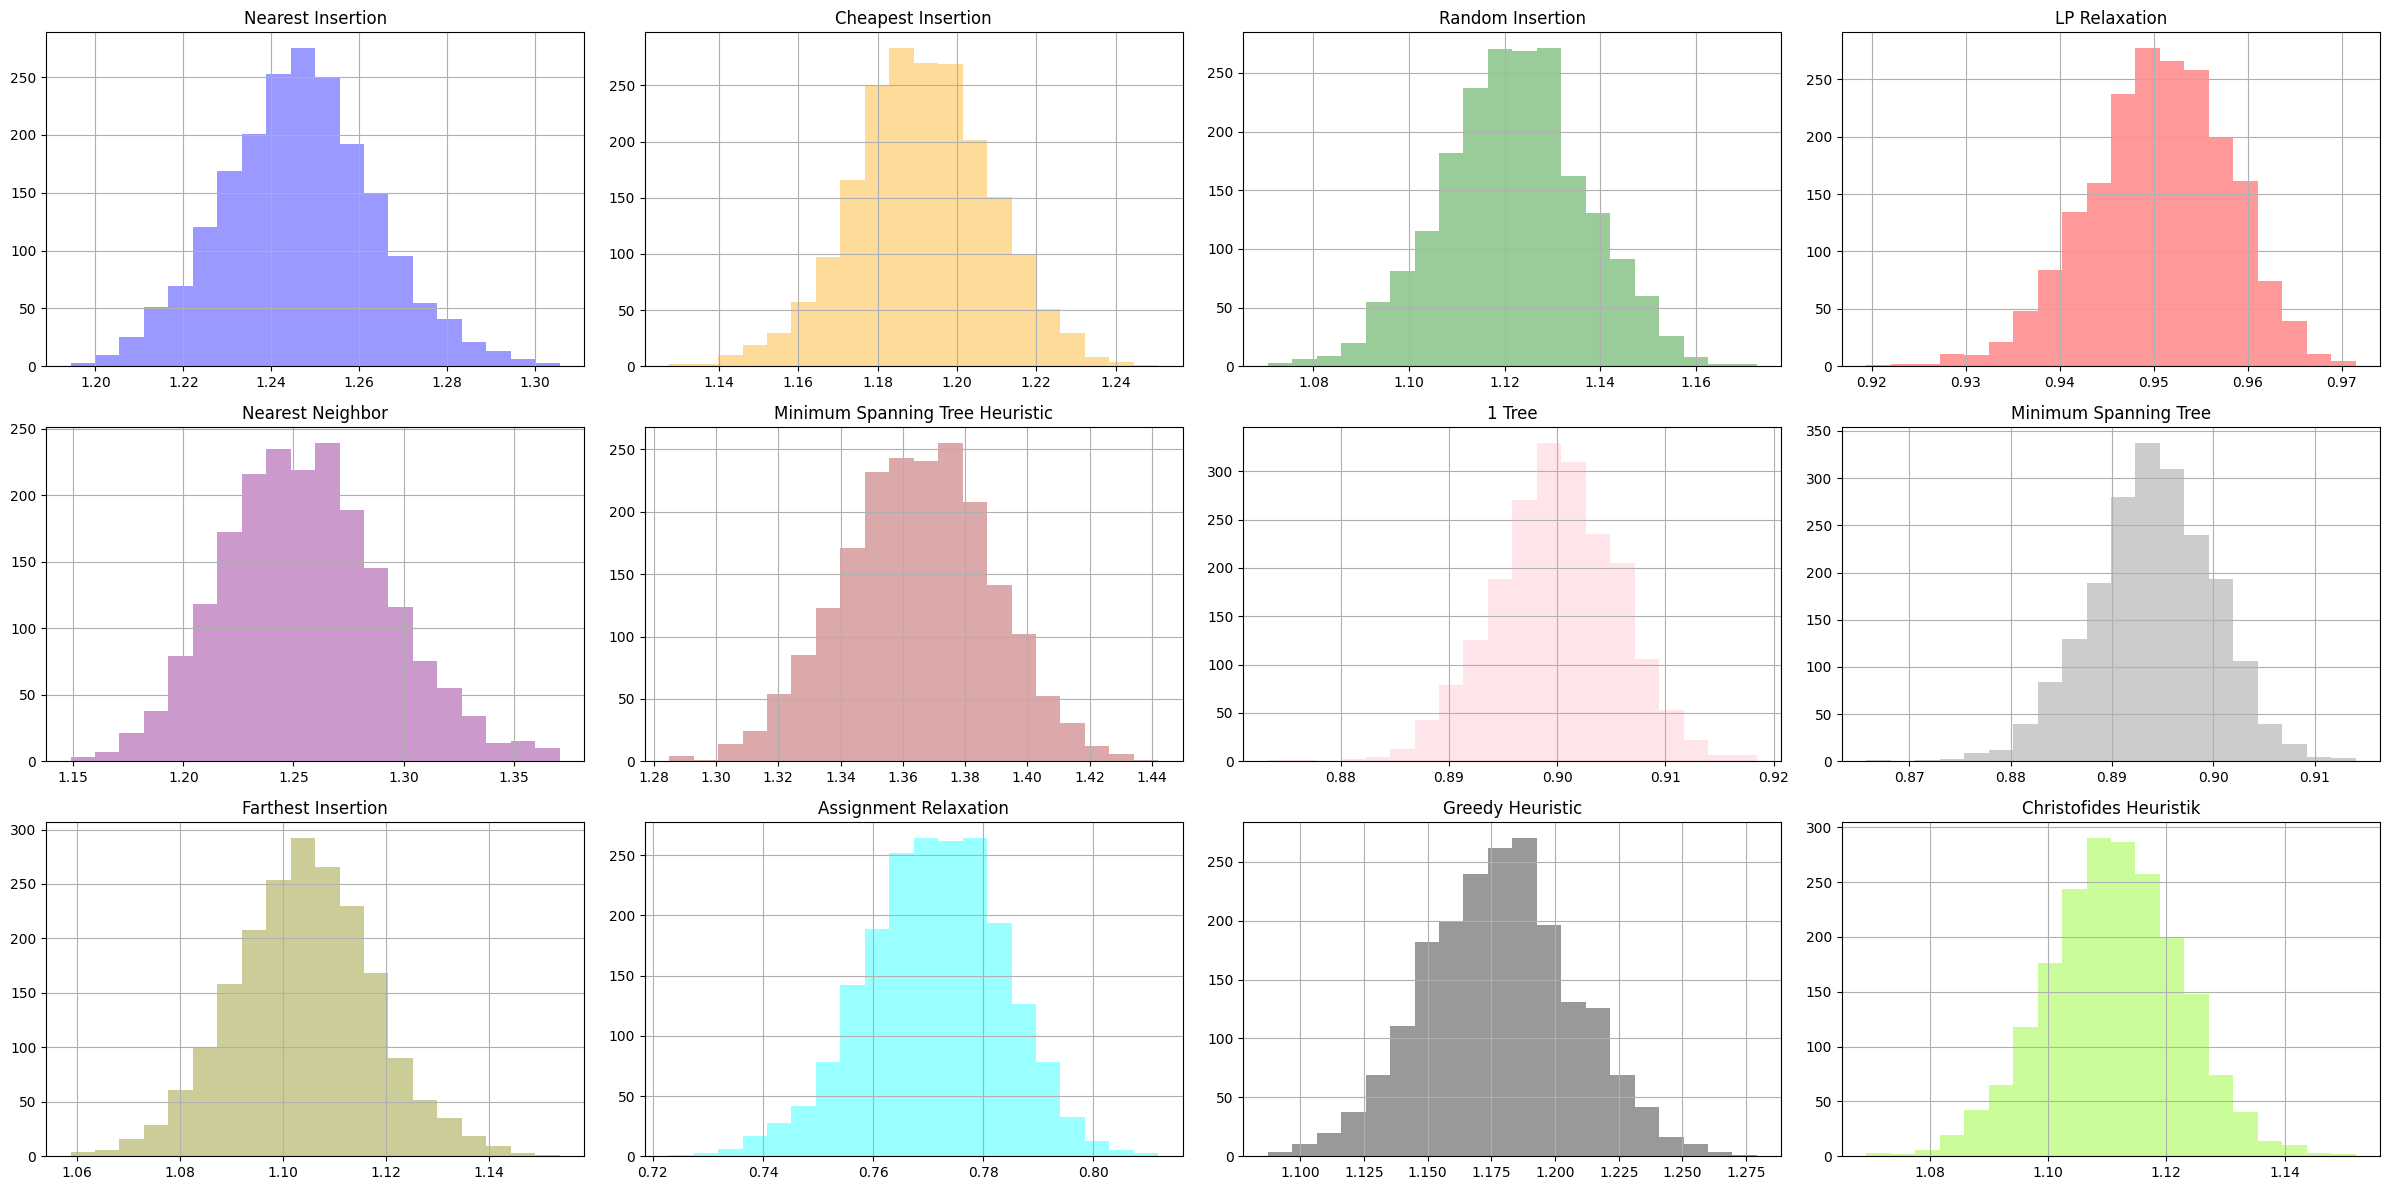

In [9]:
perc_dev_from_opt = {}
for key, value in heuristics1.items():
    if key == 'opt':
        continue
    distance = heuristics1['opt'] - value
    rel_distance = distance / heuristics1['opt']
    perc_dev_from_opt[key] = 1 - rel_distance

visualise_heuristics_distribution(perc_dev_from_opt)

### Durchschnittliche Abweichungen von optimaler Tour

In [10]:
# computing deviations for heuristics
devs = {}
for key, value in perc_dev_from_opt.items():
    display_name = heuristic_names[key]
    devs[display_name] = []
    devs[display_name].append(np.median(value))
    devs[display_name].append(np.mean(value))


df = pd.DataFrame(data=devs, index=['Median', 'Mean'])

# disabeling statement has no effect for notebook functionality
# pylint: disable=E0602
display(df.drop(columns=['Assignment Relaxation', 'LP Relaxation']).T)

Median      Mean
Nearest Insertion                1.246618  1.246526
Cheapest Insertion               1.191330  1.191171
Random Insertion                 1.121979  1.121880
Nearest Neighbor                 1.254825  1.255869
Minimum Spanning Tree Heuristic  1.365463  1.364788
1 Tree                           0.899955  0.899949
Minimum Spanning Tree            0.894225  0.894054
Farthest Insertion               1.104330  1.104064
Greedy Heuristic                 1.178439  1.178128
Christofides Heuristik           1.111340  1.111159

### Visualisierung einer optimalen TSP Tour im Datensatz

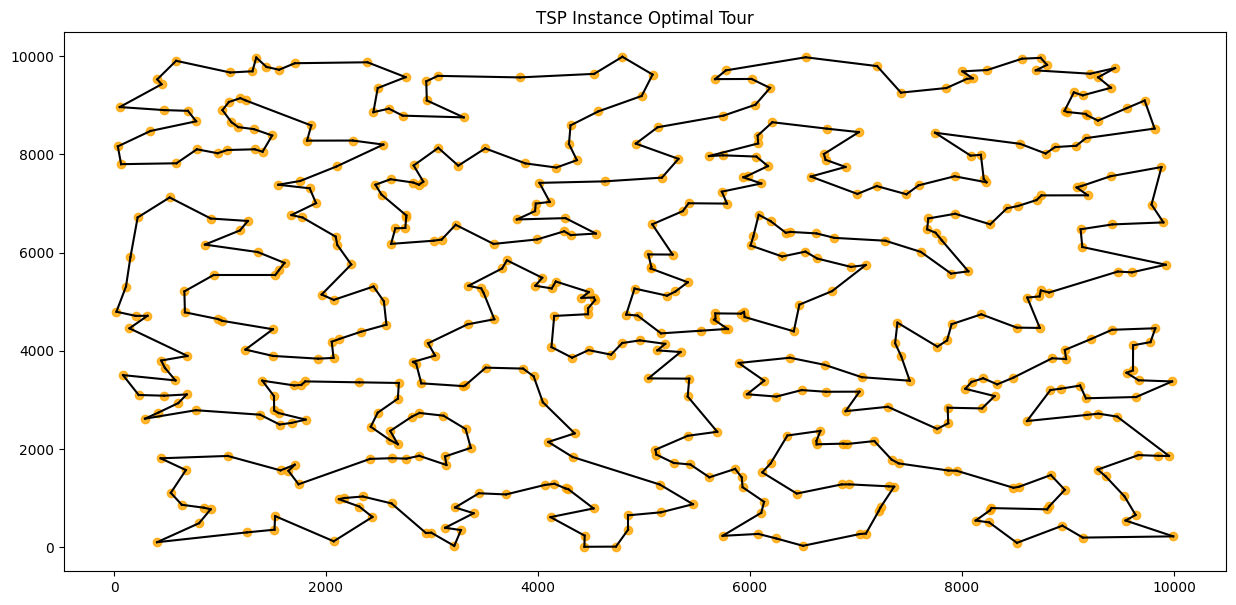

In [11]:
instance = instances1[300]

coordinates = np.array(instance['node_coordinates'])

visualise_tour(coordinates, instance['tour'], title='TSP Instance Optimal Tour')

### Heuristiken und optimale TSP Tour in relation zur Größe (|V|) des Graphs

In [12]:
# delete illegal heuristics
del heuristics1['assrel']
del heuristics1['lplb']
del heuristics1['ci']

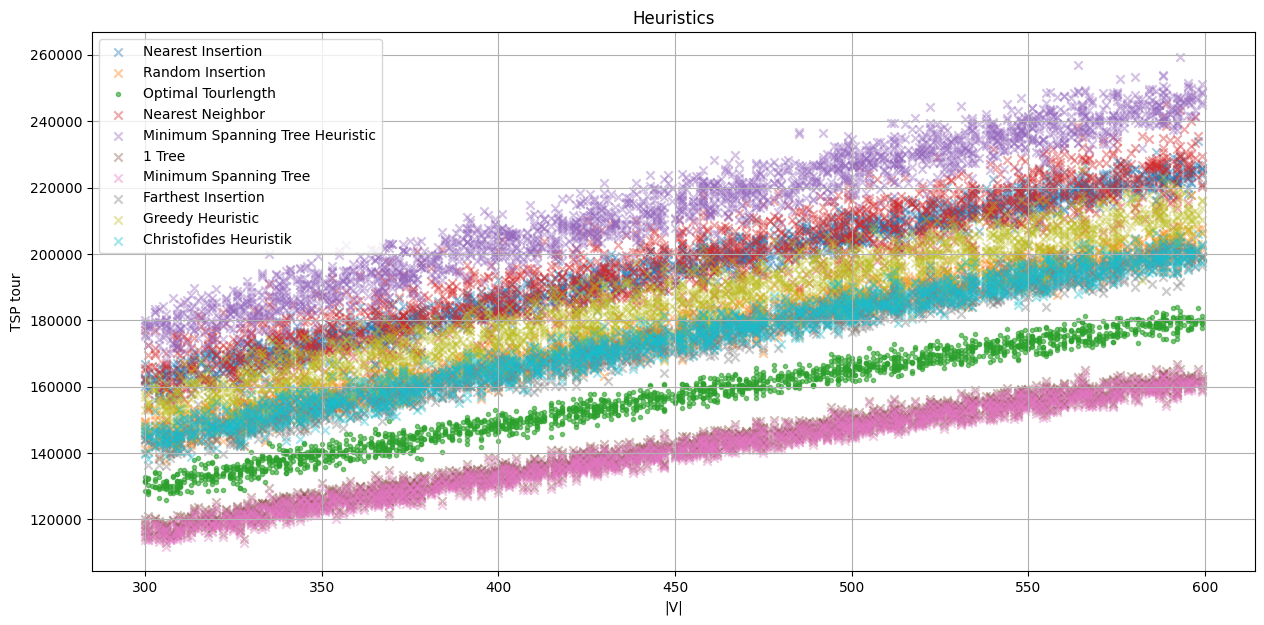

In [13]:
V = [len(x['node_coordinates']) for x in instances1]

visualise_heuristics(heuristics1, V)

### Regressionsmodelle zur vorhersage des Werts der optimalen Tour unter Eingabe der Heuristiken

In [14]:
# moving into DataFrame structure
df_heuristics1 = pd.DataFrame(heuristics1)

# splitting data
X = df_heuristics1.drop(columns=['opt'])
y = df_heuristics1['opt']

In [15]:
# Configuring regression models
models = {
    'Multiple Linear Regression': [LinearRegression(), rg.get_instances()],
    'Decision Tree Regression': [DecisionTreeRegressor(), rg.get_instances()],
    'Neural Network Regression': [
        MLPRegressor(hidden_layer_sizes=256,random_state=101),
        rg.get_instances(partition_of_data_set=1/2, number_of_sets=100)
    ],
    'Support Vector Machine Regression': [SVR(kernel='poly'), rg.get_instances()]
}

In [16]:
# we keep collecting all r_2
r_2 = {
    'Multiple Linear Regression': [],
    'Decision Tree Regression': [],
    'Neural Network Regression': [],
    'Support Vector Machine Regression': []
}

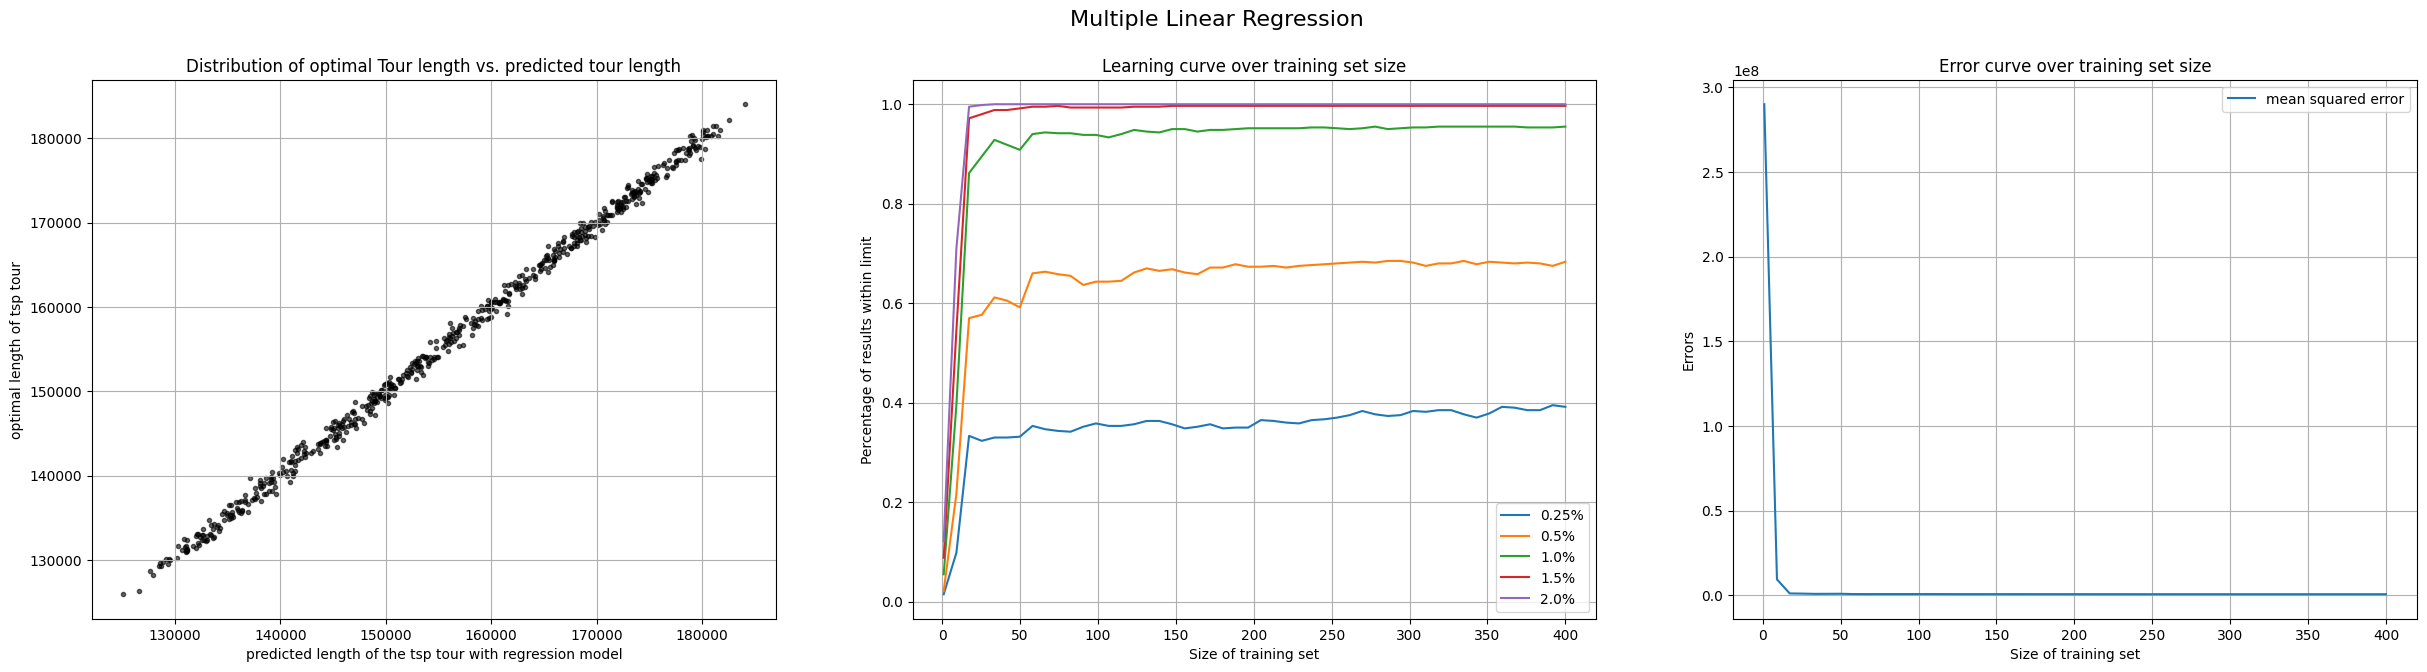

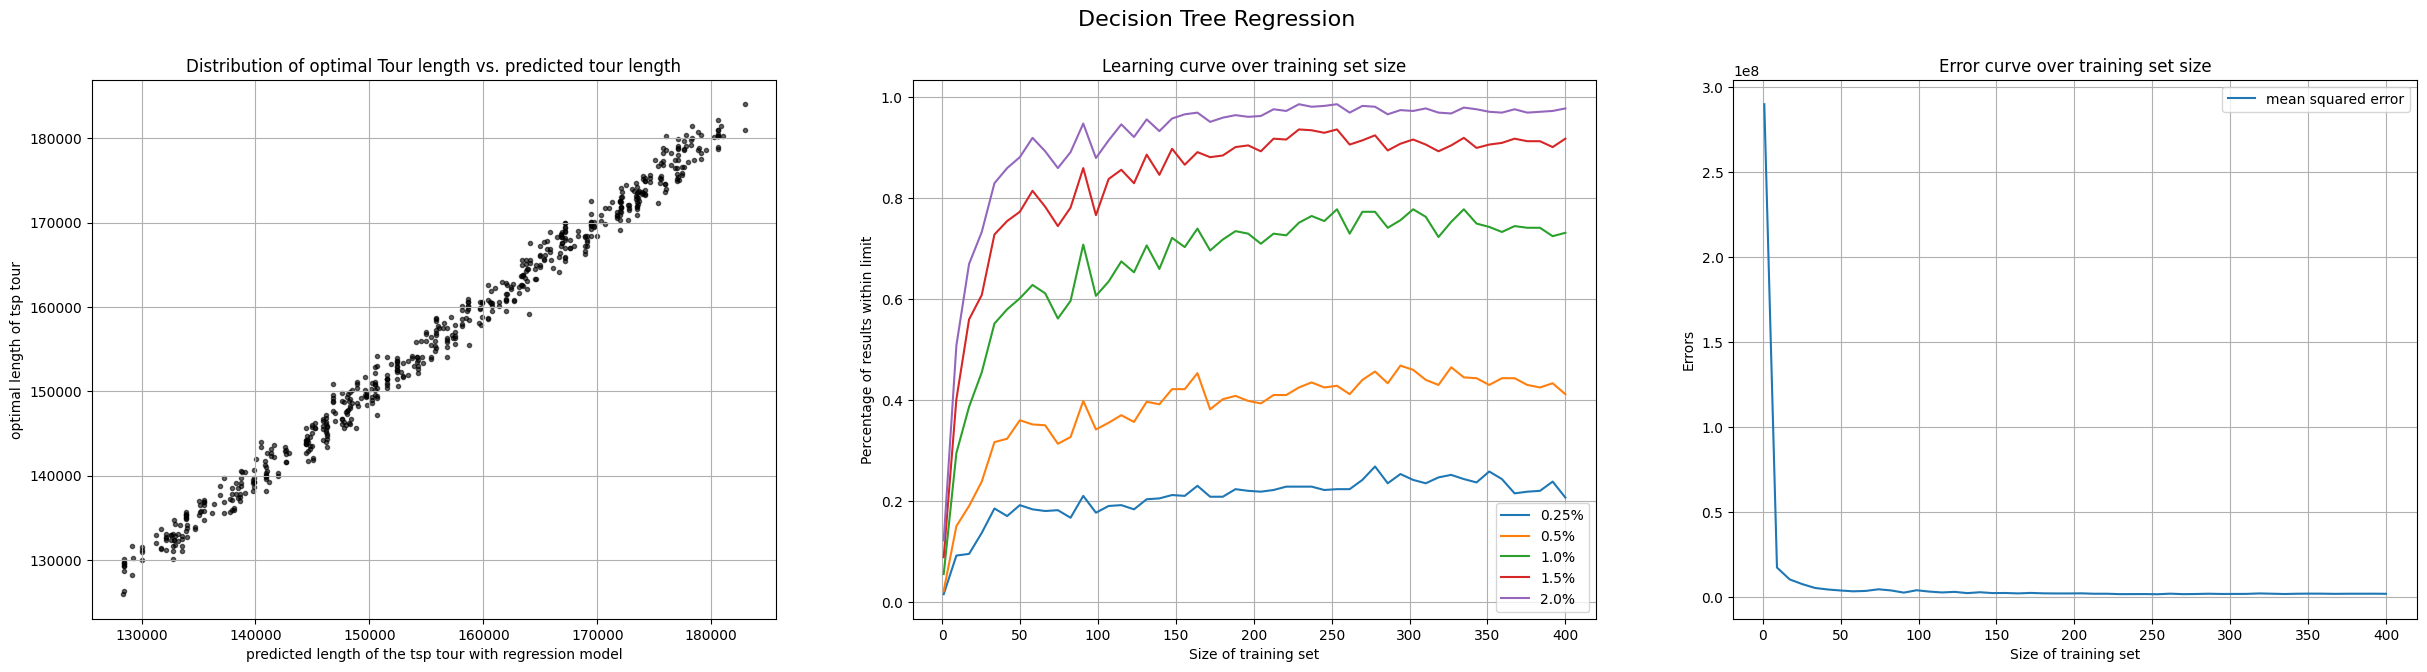

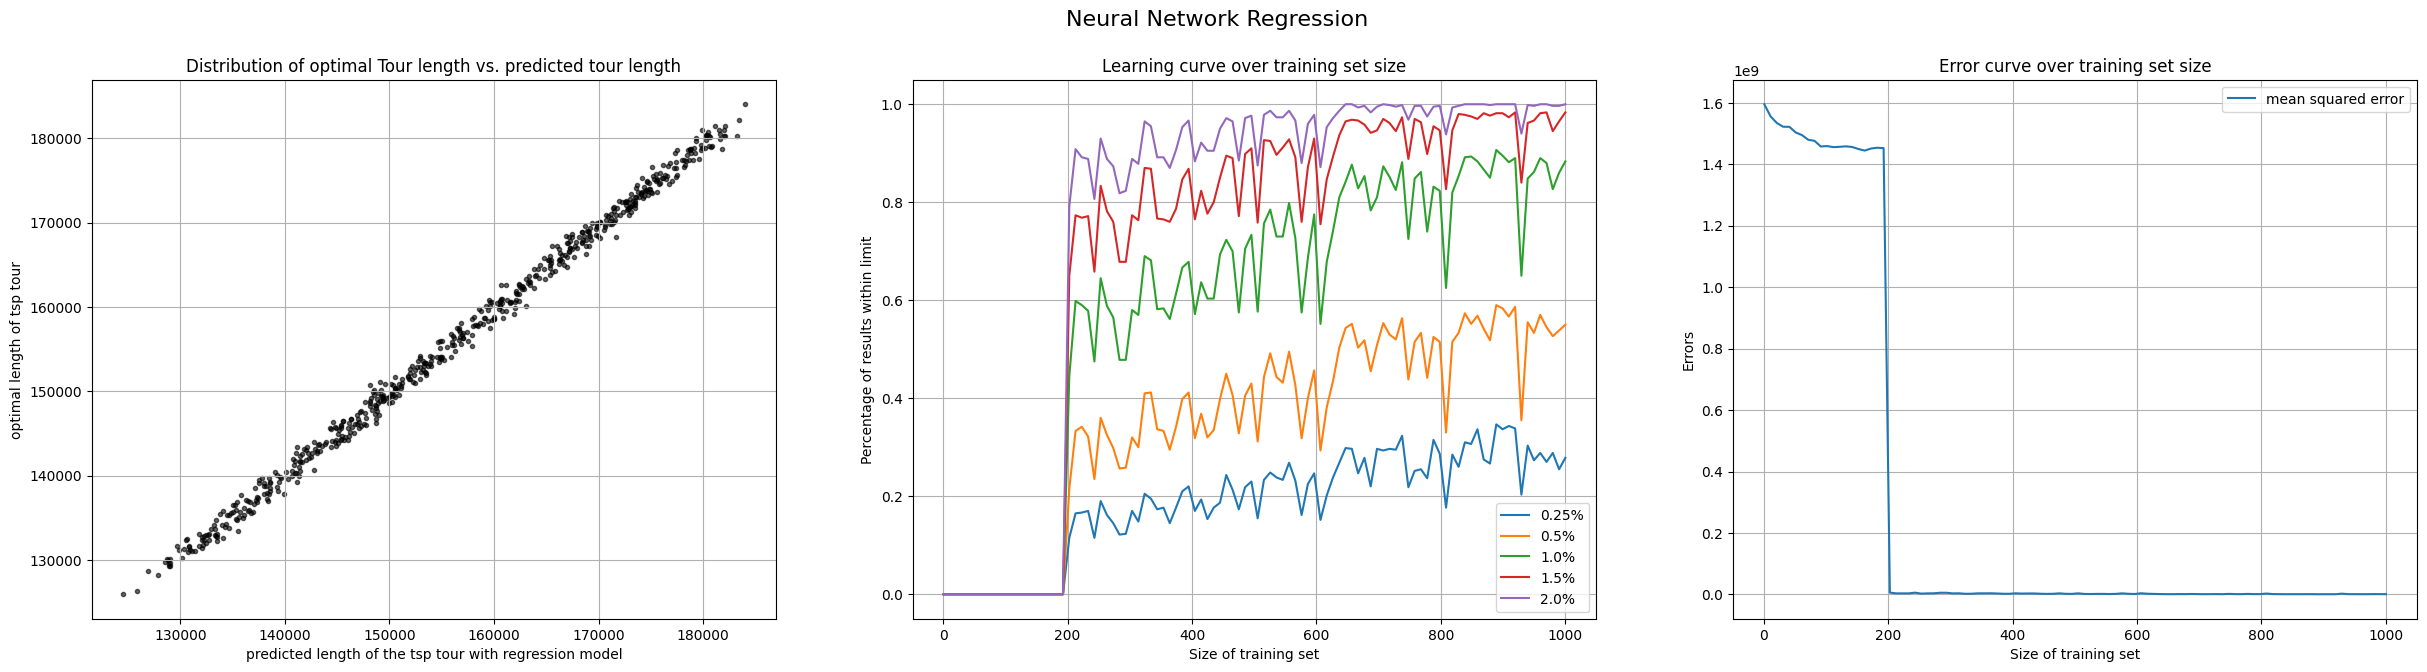

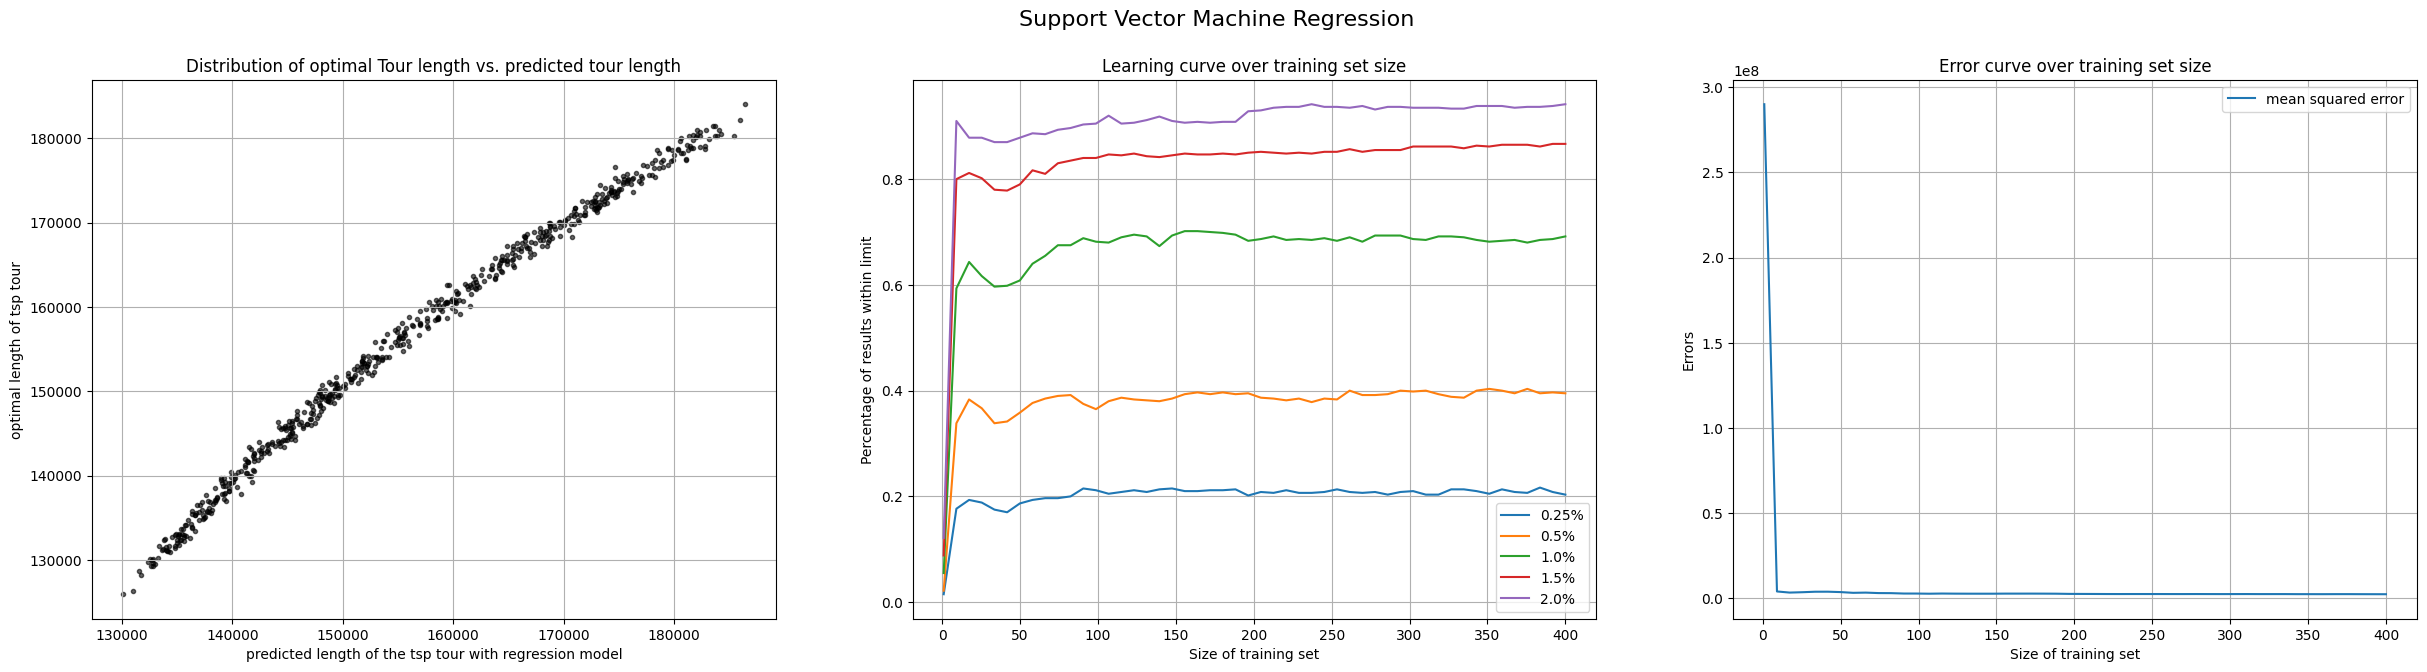

In [17]:
for name, config in models.items():
    model = config[0]
    train_set_size, results, errors = config[1]

    predictions, y_verify, results, errors = rg.train_models(
        X, y,
        model,
        train_set_size,
        results,
        errors
    )

    # atthe moment we cannot use the abs error
    del errors['mean_absolute_error']

    visualise_regression(
        predictions,
        y_verify,
        results,
        errors,
        train_set_size,
        name
    )

    r_2[name].append(r2_score(y_verify, predictions))

## Geclusterter TSP Datensatz mit mehreren Clustern

In [18]:
# Get secon dataset
heuristics2 = fo.get_all_heuristics(PATH_TSP2_HEU)
instances2 = fo.get_all_instances(PATH_TSP2)

### Prozentuelle Abweichung der Heuristiken und unteren Schranken von optimaler Tour
Werte < 1 deuten darauf hin, dass Heuristik eine untere Schranke darstellt. Werte > 1 deuten auf eine approximation der optimalen TSP Tour hin

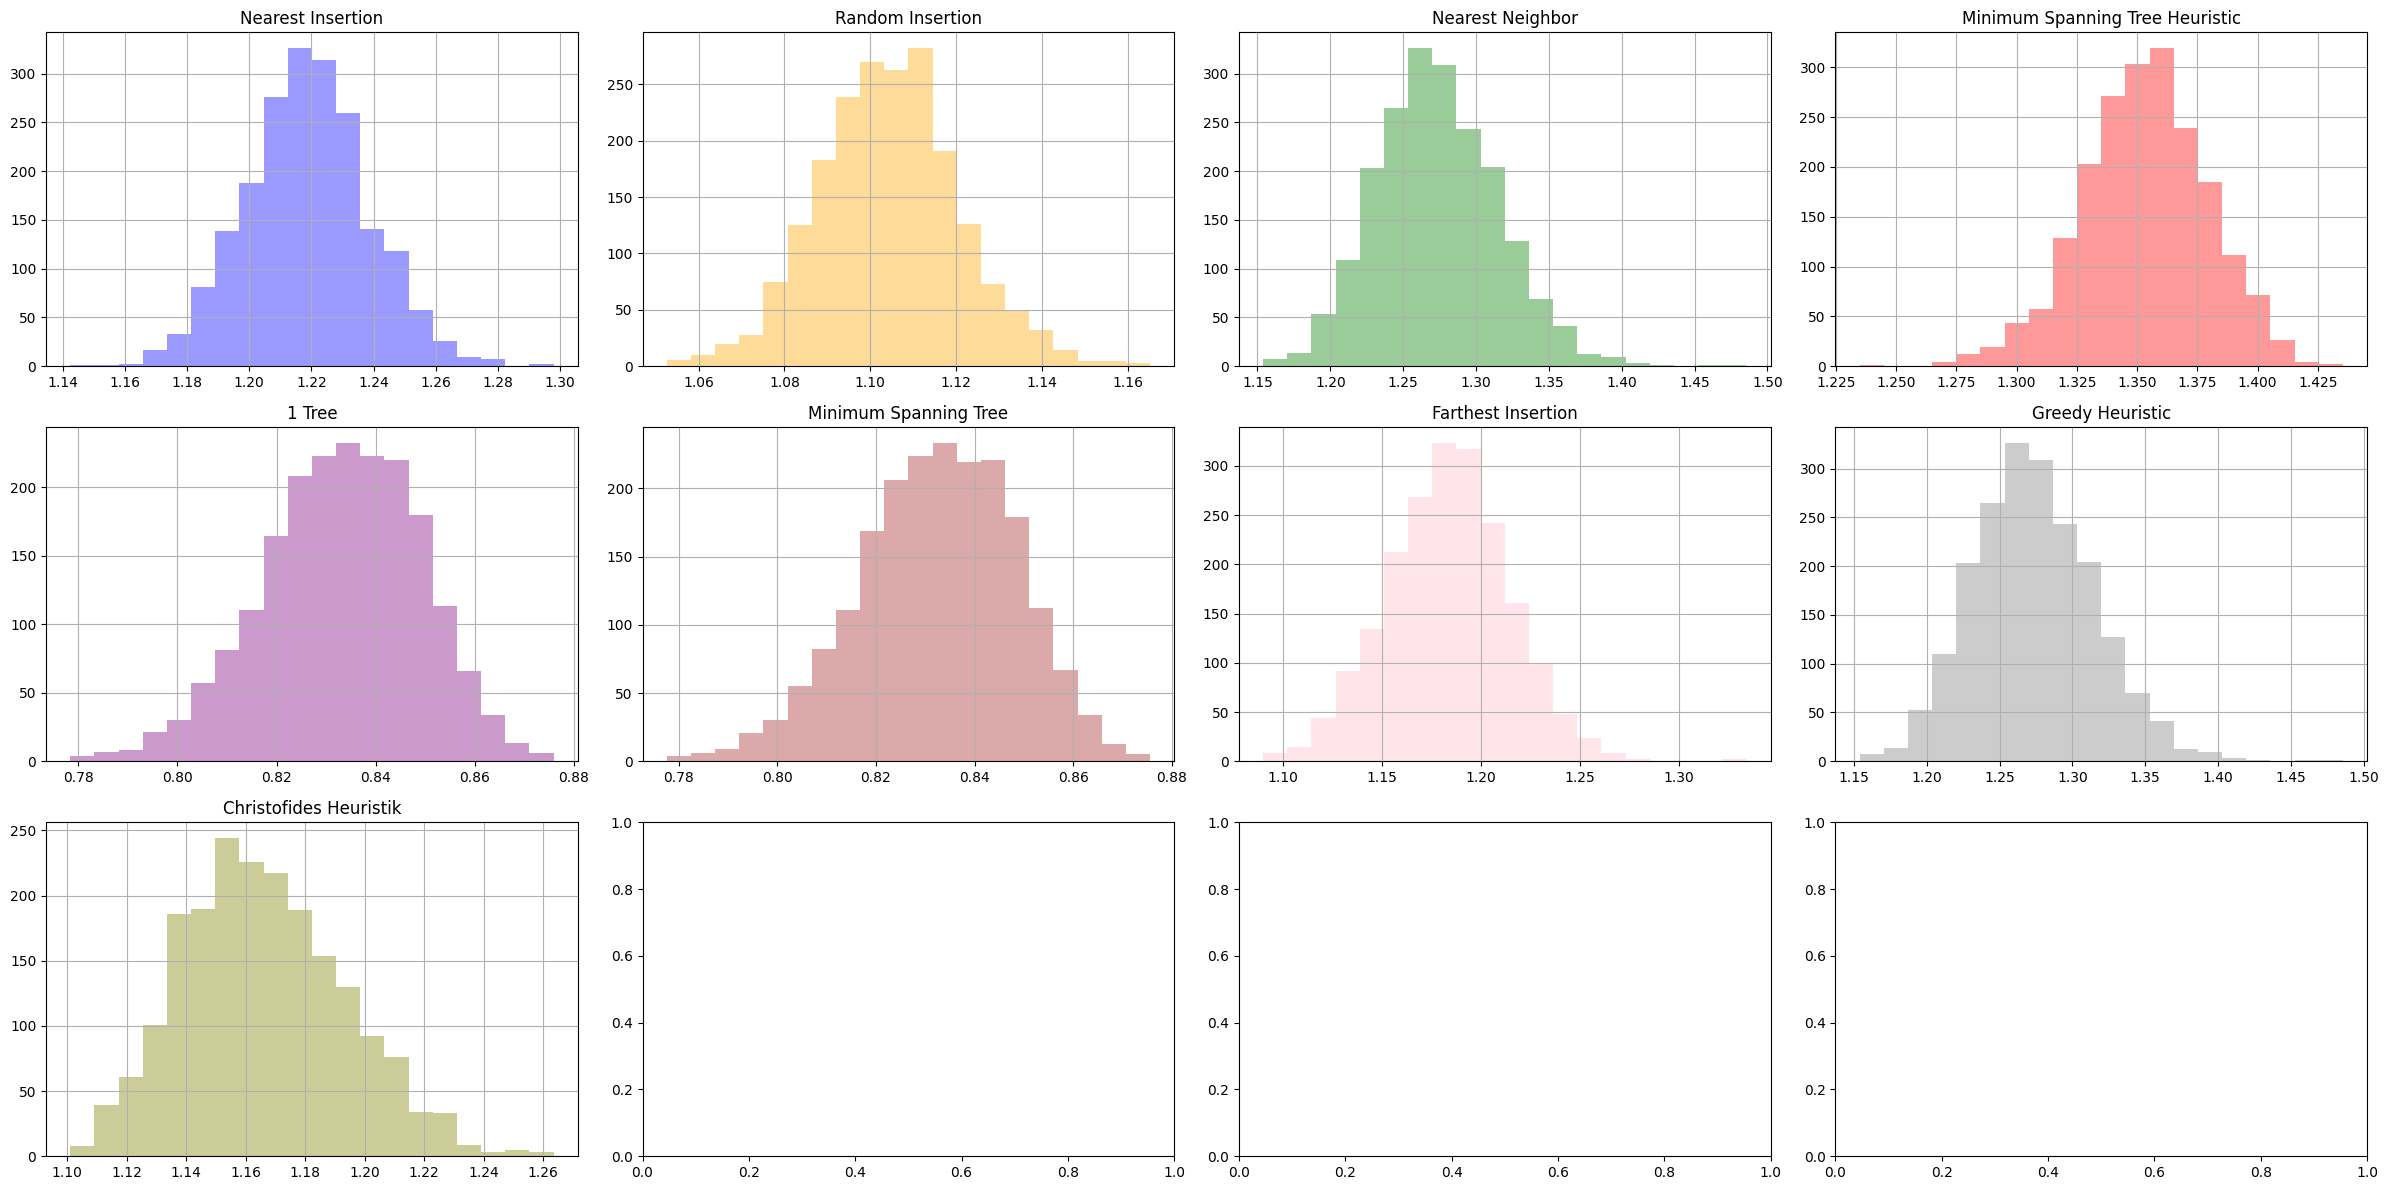

In [19]:
perc_dev_from_opt = {}
for key, value in heuristics2.items():
    if key == 'opt':
        continue
    distance = heuristics2['opt'] - value
    rel_distance = distance / heuristics2['opt']
    perc_dev_from_opt[key] = 1 - rel_distance

visualise_heuristics_distribution(perc_dev_from_opt)

### Durchschnittliche Abweichungen von optimaler Tour

In [20]:
devs = {}
for key, value in perc_dev_from_opt.items():
    display_name = heuristic_names[key]
    devs[display_name] = []
    devs[display_name].append(np.median(value))
    devs[display_name].append(np.mean(value))


df = pd.DataFrame(data=devs, index=['Median', 'Mean'])
display(df.T)

Median      Mean
Nearest Insertion                1.218762  1.218757
Random Insertion                 1.104015  1.104288
Nearest Neighbor                 1.271214  1.273434
Minimum Spanning Tree Heuristic  1.353916  1.353266
1 Tree                           0.833908  0.833093
Minimum Spanning Tree            0.833352  0.832527
Farthest Insertion               1.183940  1.183452
Greedy Heuristic                 1.271214  1.273457
Christofides Heuristik           1.163990  1.166064

### Visualisierung einer optimalen Tour im Datensatz

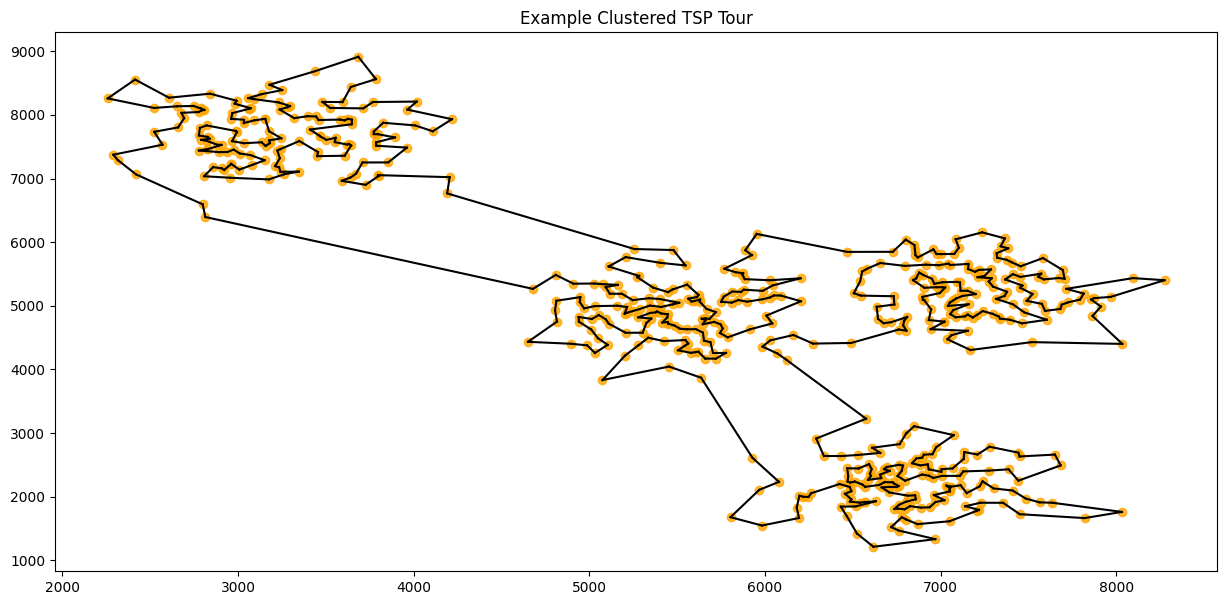

In [21]:
instance = instances2[22]
coordinates = np.array(instance['node_coordinates'])
tour = np.array(instance['tour'])
visualise_tour(coordinates, tour, title='Example Clustered TSP Tour')

### Heuristiken und optimale TSP Tour in Relation zur Größe (|V|) des Graphs

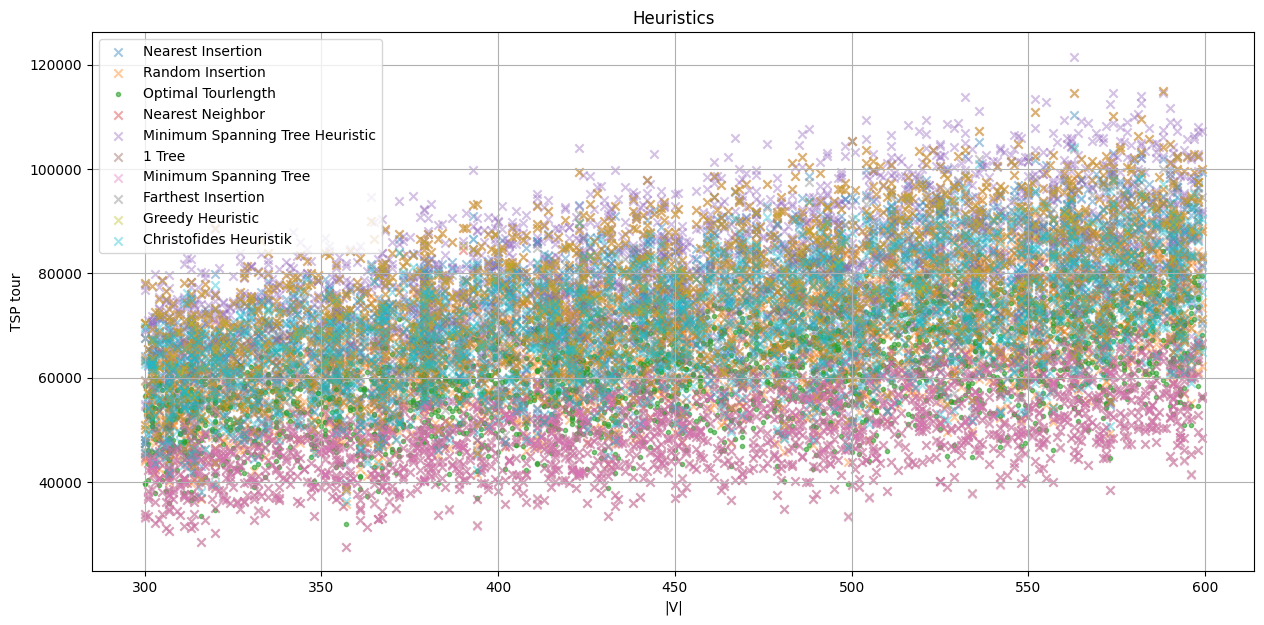

In [22]:
V = [len(x['node_coordinates']) for x in instances2]

visualise_heuristics(heuristics2, V)

### Regressionsmodelle zur Vorhersage des Werts der optimalen Tour unter Eingabe der Heuristiken

In [23]:
# moving into DataFrame structure
df_heuristics2 = pd.DataFrame(heuristics2)

# splitting data
X = df_heuristics2.drop(columns=['opt'])
y = df_heuristics2['opt']

In [24]:
# Configuring regression models
models = {
    'Multiple Linear Regression': [LinearRegression(), rg.get_instances()],
    'Decision Tree Regression': [DecisionTreeRegressor(), rg.get_instances()],
    'Neural Network Regression': [
        MLPRegressor(hidden_layer_sizes=256,random_state=101),
        rg.get_instances(partition_of_data_set=1/2, number_of_sets=100)
    ],
    'Support Vector Machine Regression': [SVR(kernel='poly'), rg.get_instances()]
}

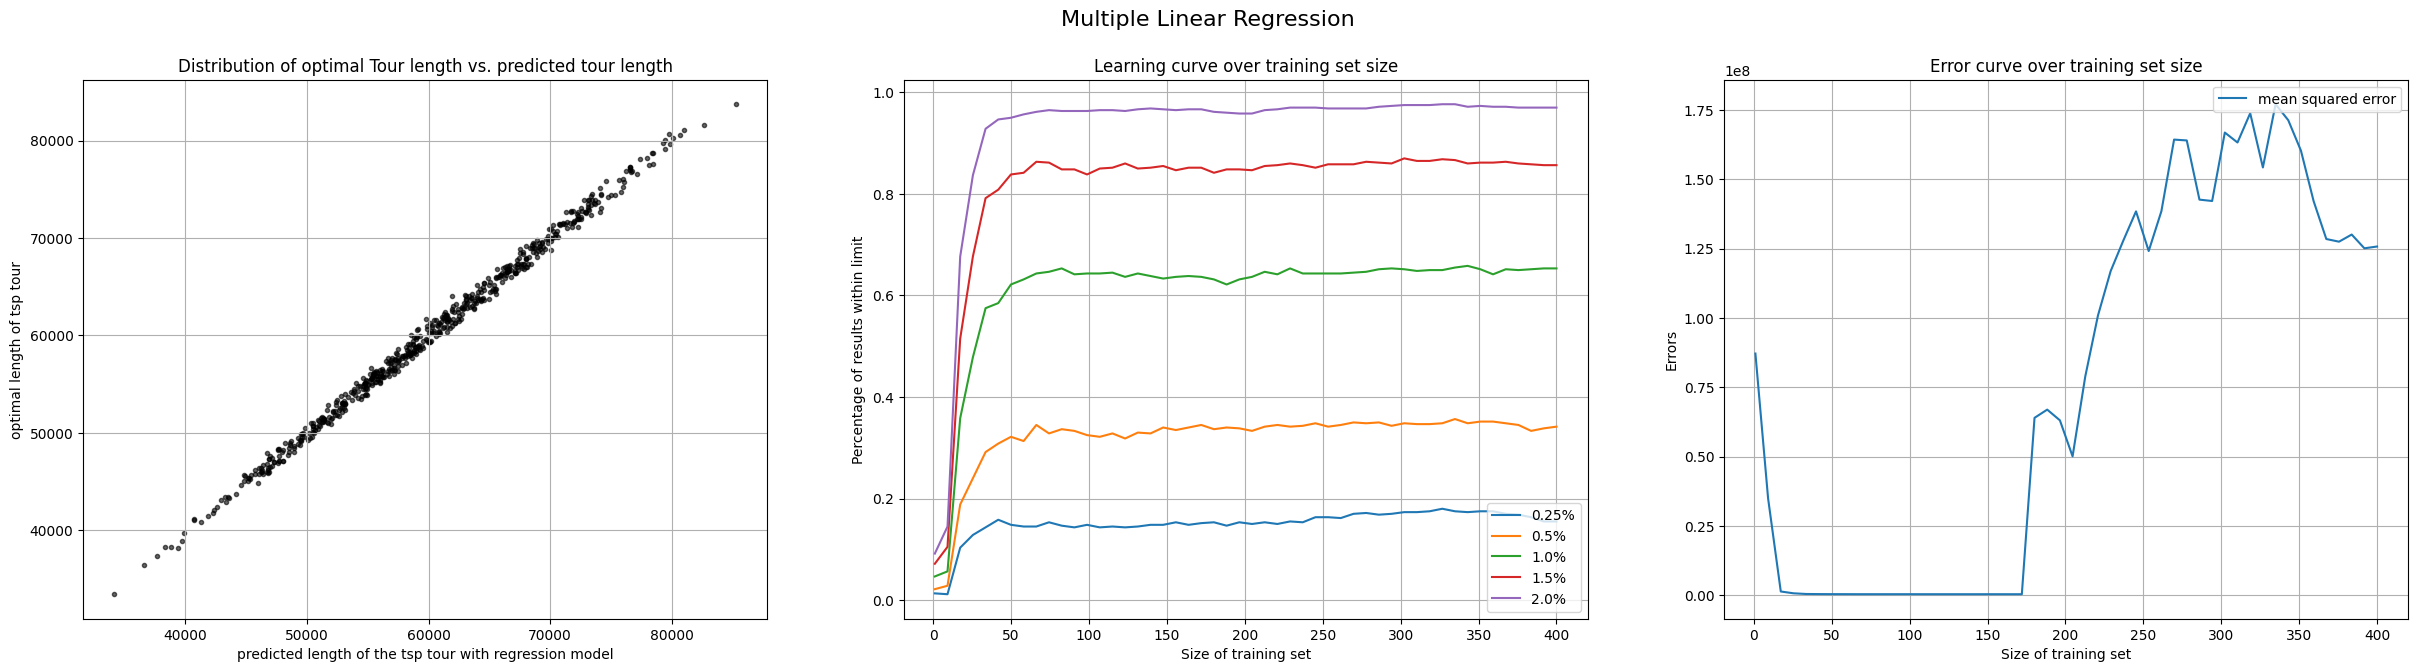

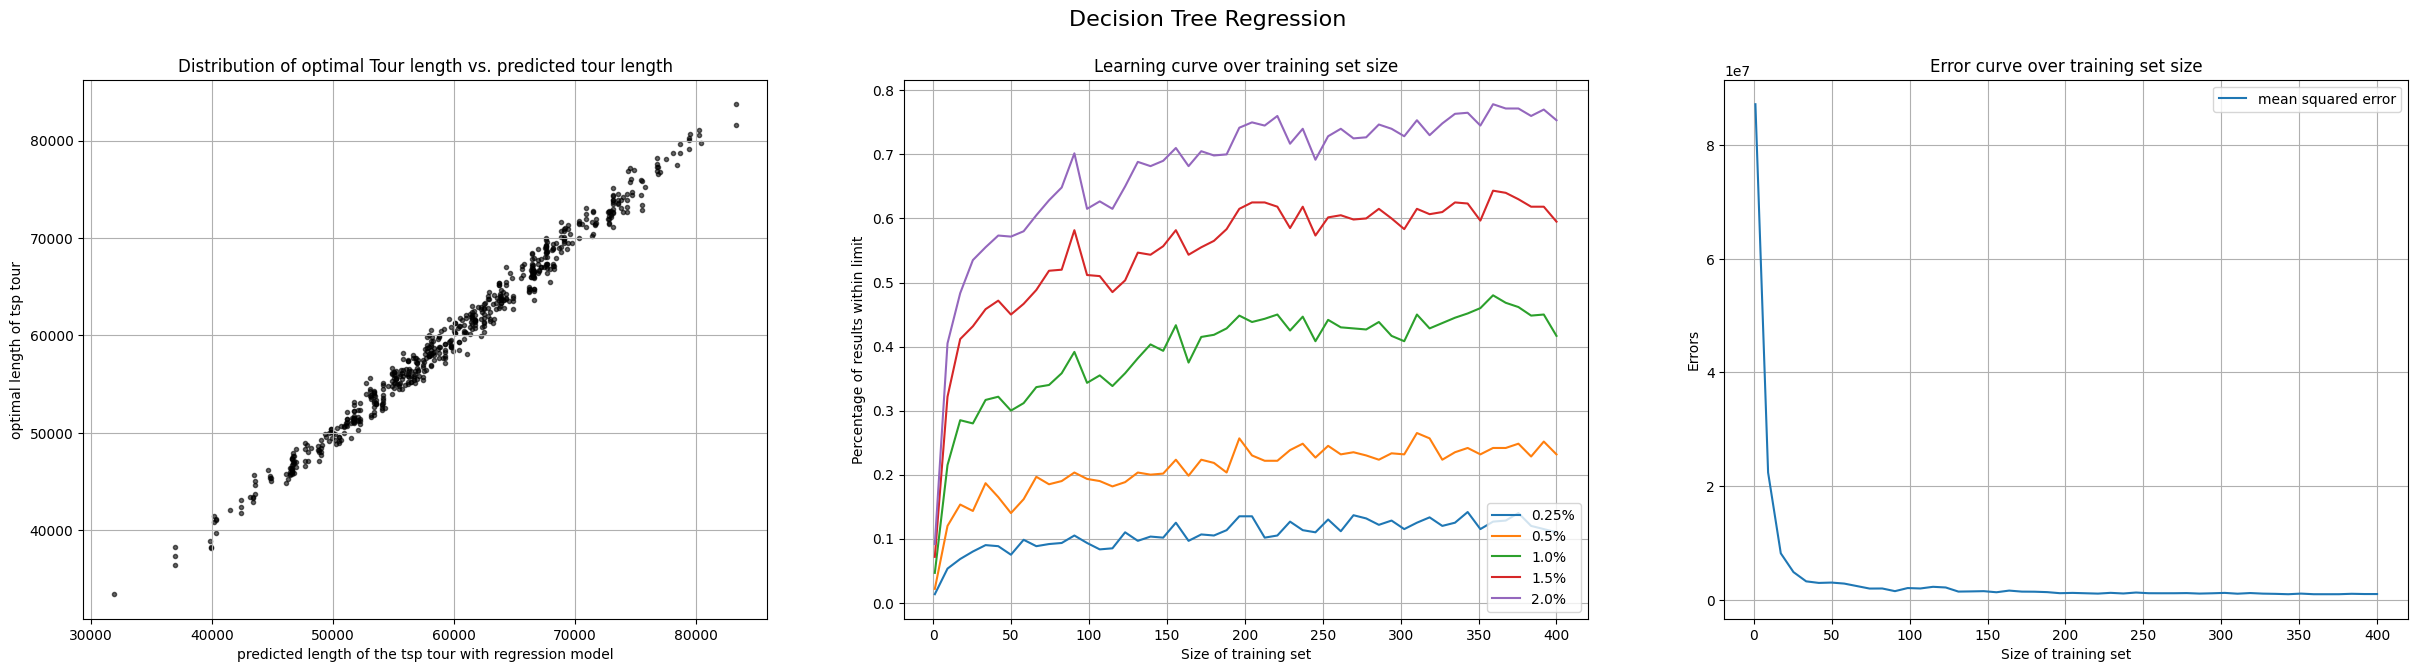

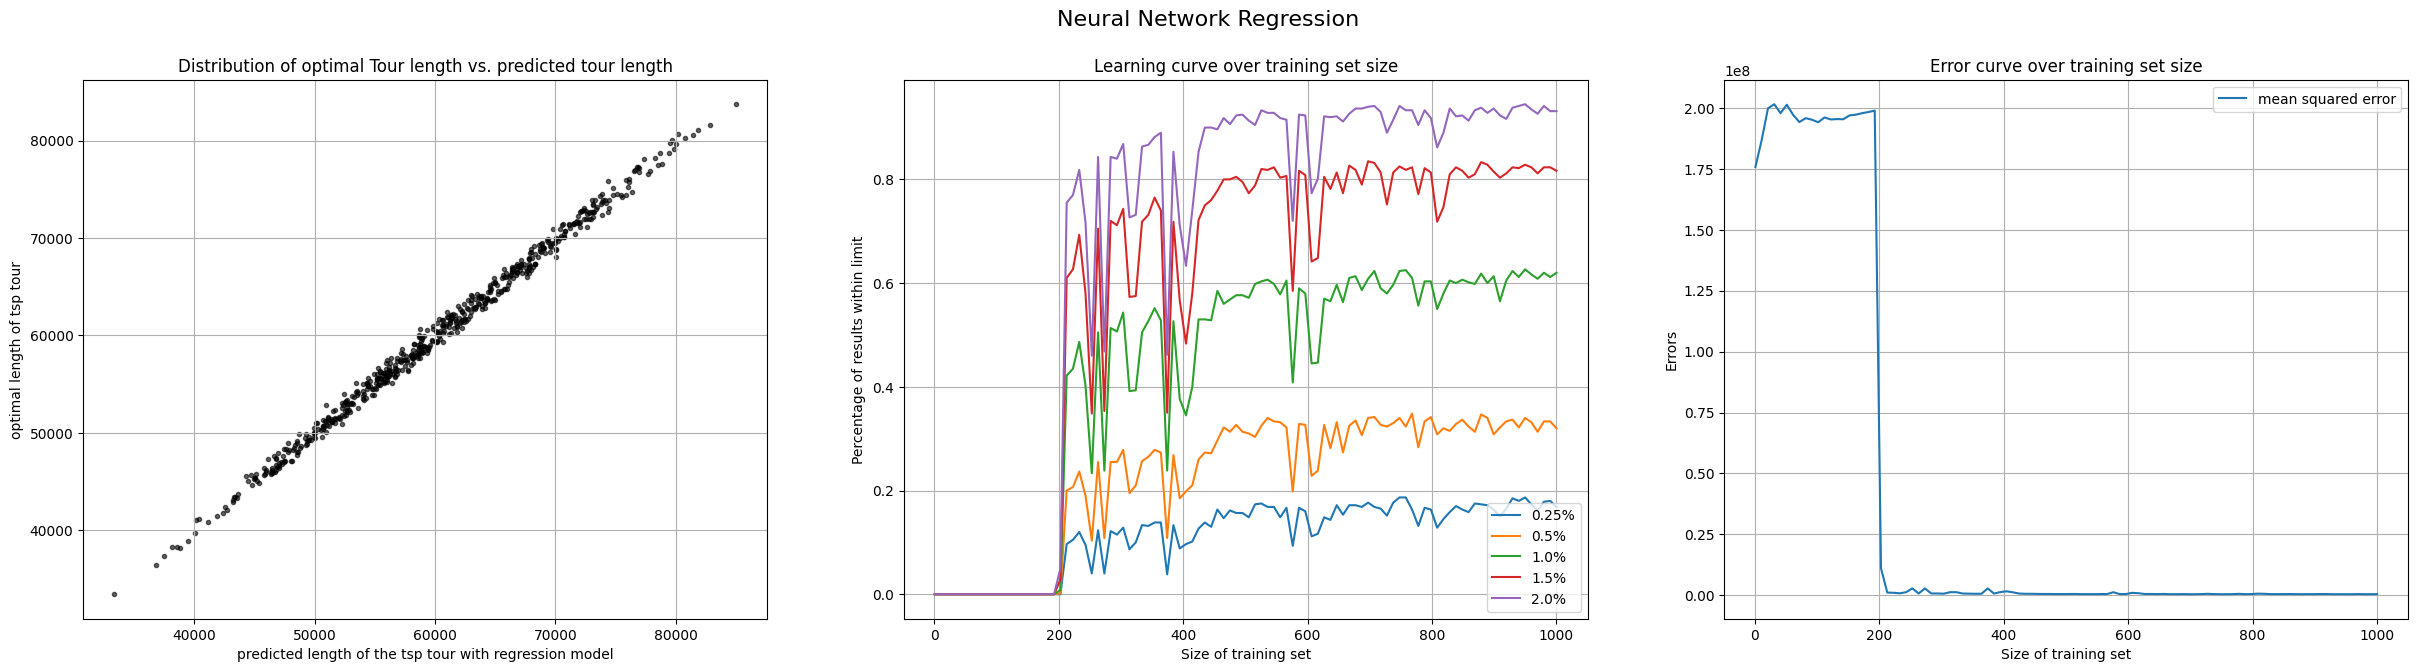

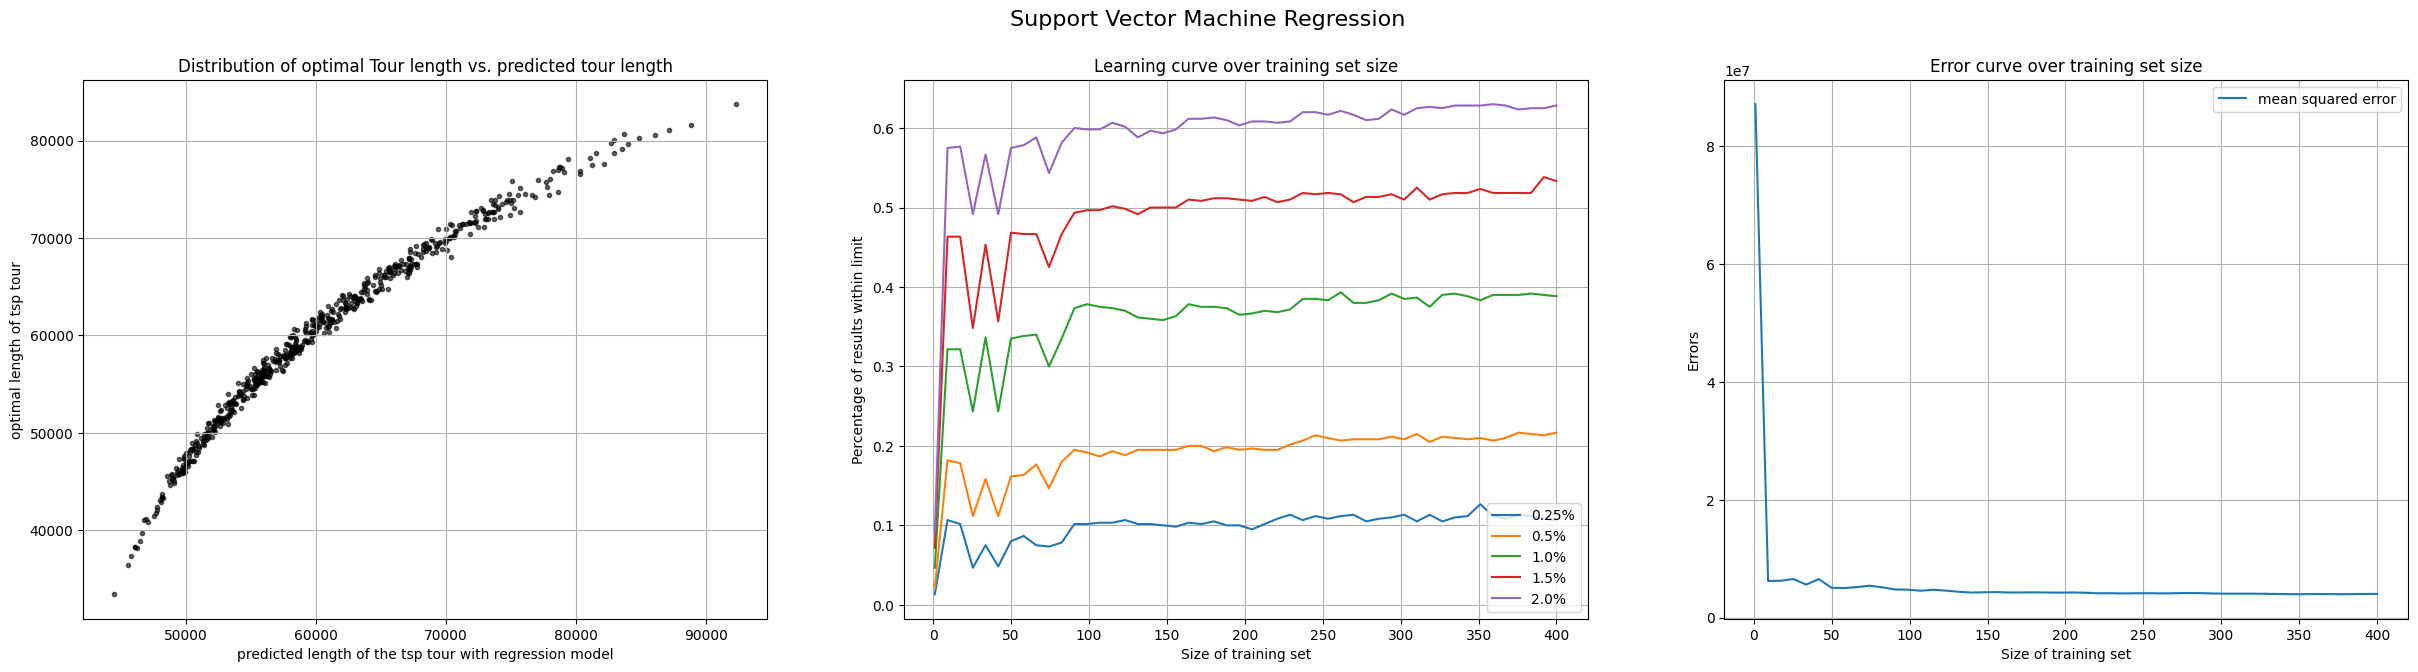

In [25]:
for name, config in models.items():
    model = config[0]
    train_set_size, results, errors = config[1]

    predictions, y_verify, results, errors = rg.train_models(
        X, y,
        model,
        train_set_size,
        results,
        errors
    )

    # eliminate outliers
    y_verify = list(y_verify)
    predictions = list(predictions)
    for i,p in enumerate(predictions):
        if p > 150000:
            del predictions[i]
            del y_verify[i]

    # atthe moment we cannot use the abs error
    del errors['mean_absolute_error']

    visualise_regression(
        predictions,
        y_verify,
        results,
        errors,
        train_set_size,
        name
    )

    r_2[name].append(r2_score(y_verify, predictions))

## Geclusterter Datensatz mit einfachen Clustern

In [26]:
# Get secon dataset
heuristics3 = fo.get_all_heuristics(PATH_TSP3_HEU)
instances3 = fo.get_all_instances(PATH_TSP3)

### Prozentuelle Abweichung der Heuristiken und unteren Schranke von optimaler Tour

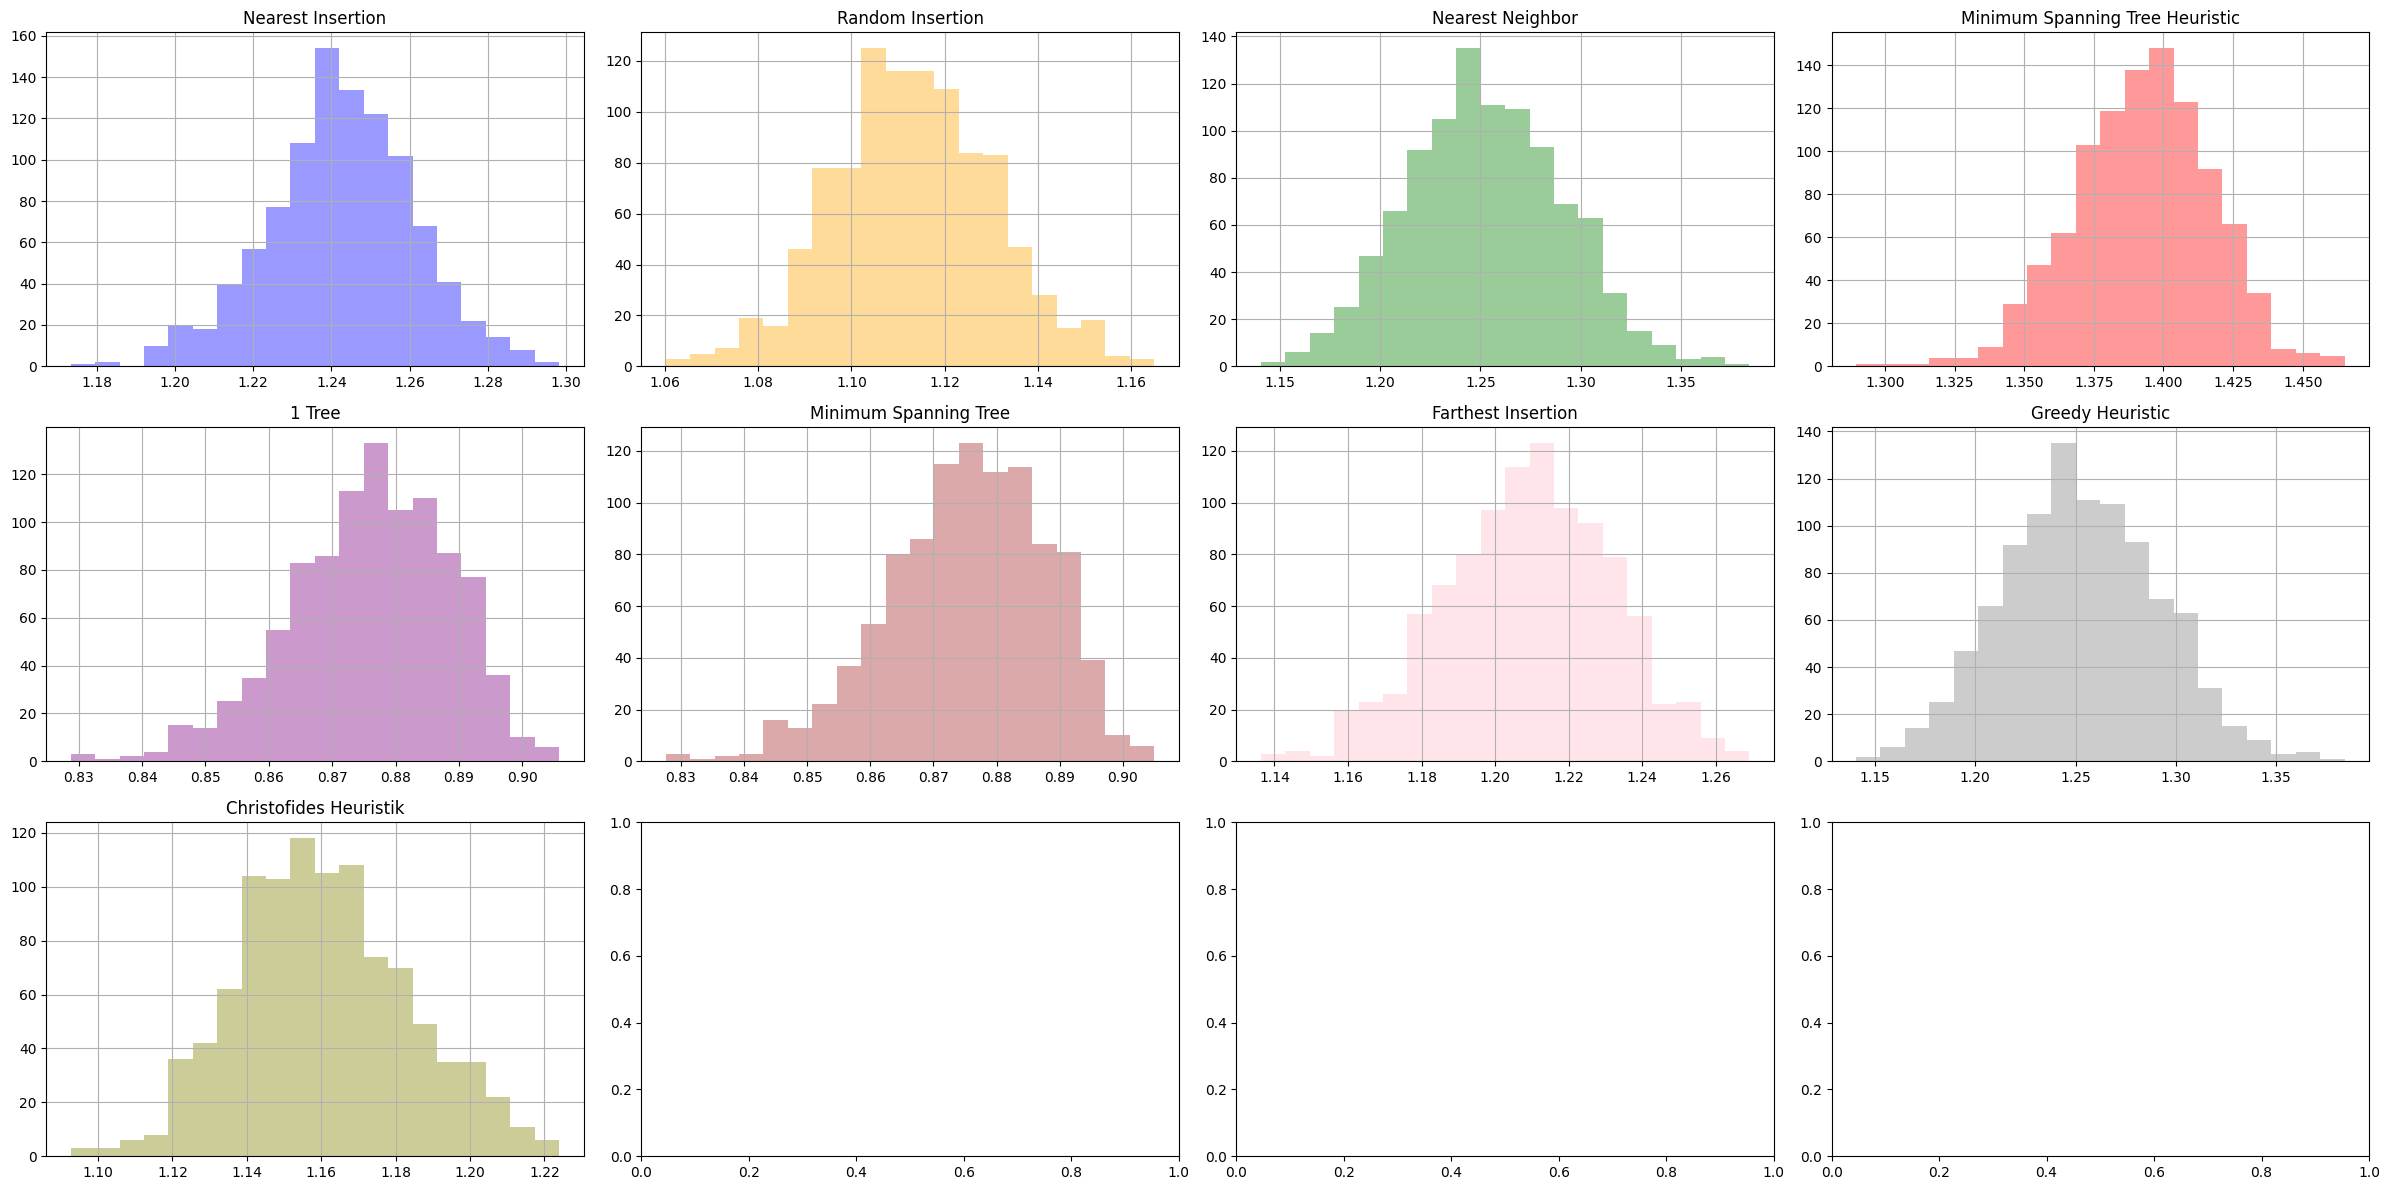

In [27]:
perc_dev_from_opt = {}
for key, value in heuristics3.items():
    if key == 'opt':
        continue
    distance = heuristics3['opt'] - value
    rel_distance = distance / heuristics3['opt']
    perc_dev_from_opt[key] = 1 - rel_distance

visualise_heuristics_distribution(perc_dev_from_opt)

### Durchschnittliche Abweichung von optimaler Tour

In [28]:
devs = {}
for key, value in perc_dev_from_opt.items():
    display_name = heuristic_names[key]
    devs[display_name] = []
    devs[display_name].append(np.median(value))
    devs[display_name].append(np.mean(value))


df = pd.DataFrame(data=devs, index=['Median', 'Mean'])
display(df.T)

Median      Mean
Nearest Insertion                1.242698  1.242368
Random Insertion                 1.112861  1.113247
Nearest Neighbor                 1.251149  1.252406
Minimum Spanning Tree Heuristic  1.393818  1.392549
1 Tree                           0.876593  0.876003
Minimum Spanning Tree            0.875955  0.875314
Farthest Insertion               1.209579  1.208780
Greedy Heuristic                 1.251149  1.252406
Christofides Heuristik           1.159143  1.160816

### Visualisierung einer optimalen Tour im Datensatz

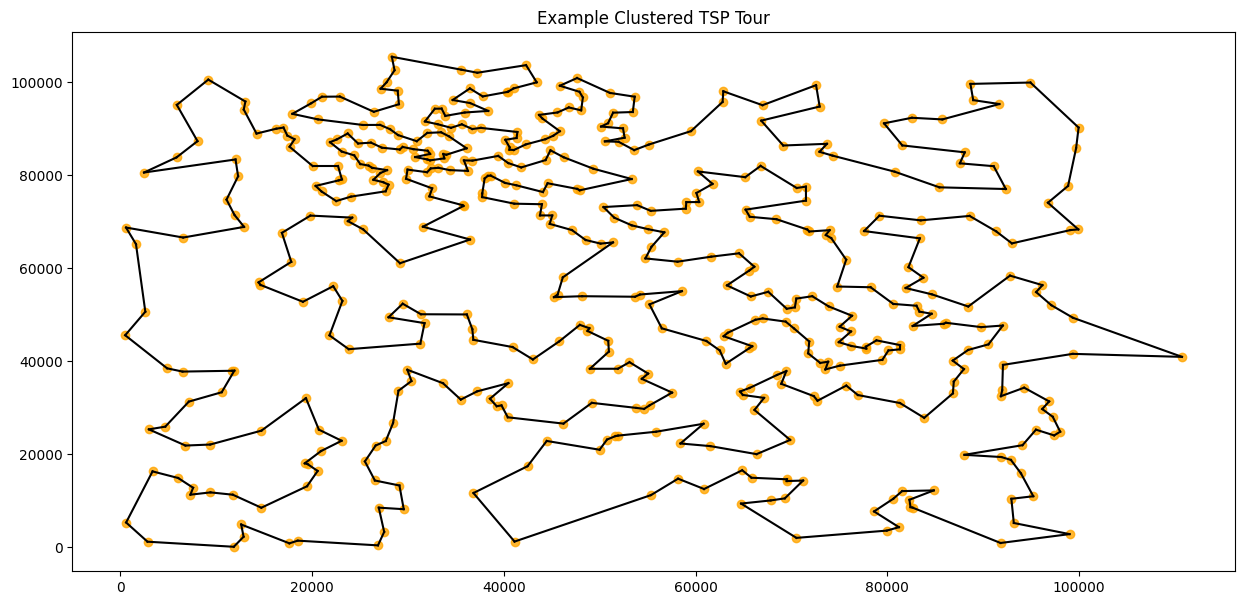

In [29]:
instance = instances3[35]
coordinates = np.array(instance['node_coordinates'])
tour = np.array(instance['tour'])
visualise_tour(coordinates, tour, title='Example Clustered TSP Tour')

### Heuristiken und optimale TSP Tour in Relation zur Größe (|V|) des Graphs

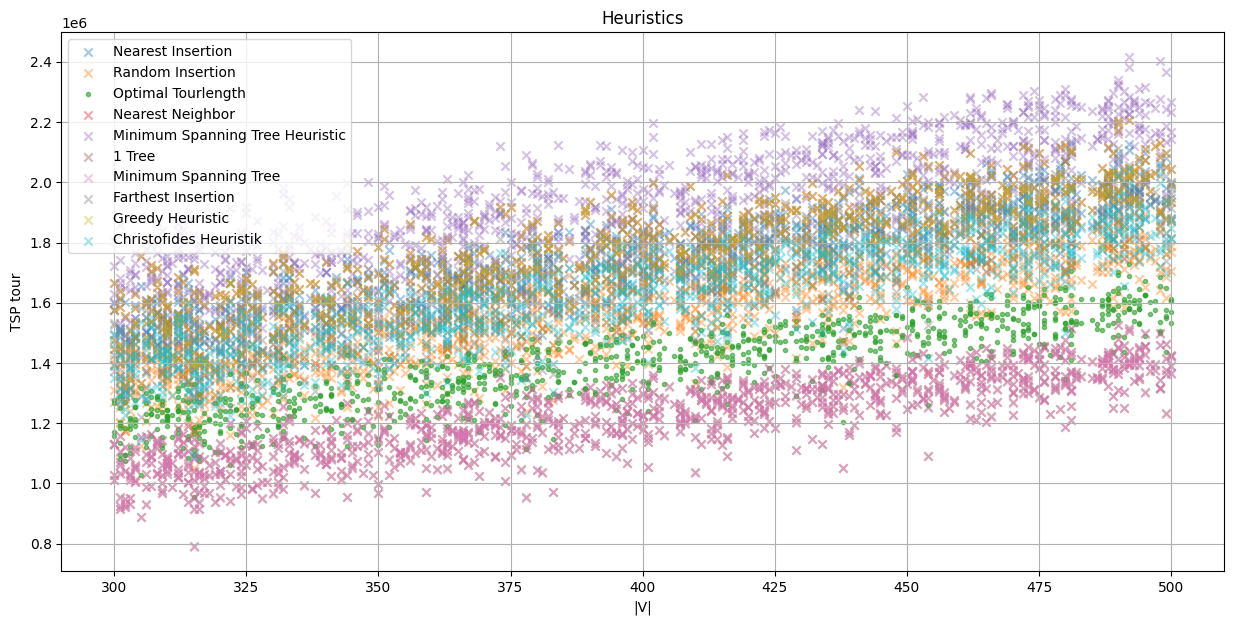

In [30]:
V = [len(x['node_coordinates']) for x in instances3]

visualise_heuristics(heuristics3, V)

### Regressionsmodelle zur Vorhersage des optimalen Werts unter Eingabe der Heuristiken

In [31]:
# moving into DataFrame structure
df_heuristics3 = pd.DataFrame(heuristics3)

# splitting data
X = df_heuristics3.drop(columns=['opt'])
y = df_heuristics3['opt']

In [32]:
# Configuring regression models
models = {
    'Multiple Linear Regression': [LinearRegression(), rg.get_instances(len_dataset=1000)],
    'Decision Tree Regression': [DecisionTreeRegressor(), rg.get_instances(len_dataset=1000)],
    'Neural Network Regression': [
        MLPRegressor(hidden_layer_sizes=256,random_state=101),
        rg.get_instances(len_dataset=1000, partition_of_data_set=1/2, number_of_sets=100)
    ],
    'Support Vector Machine Regression': [SVR(kernel='poly'), rg.get_instances(len_dataset=1000)]
}

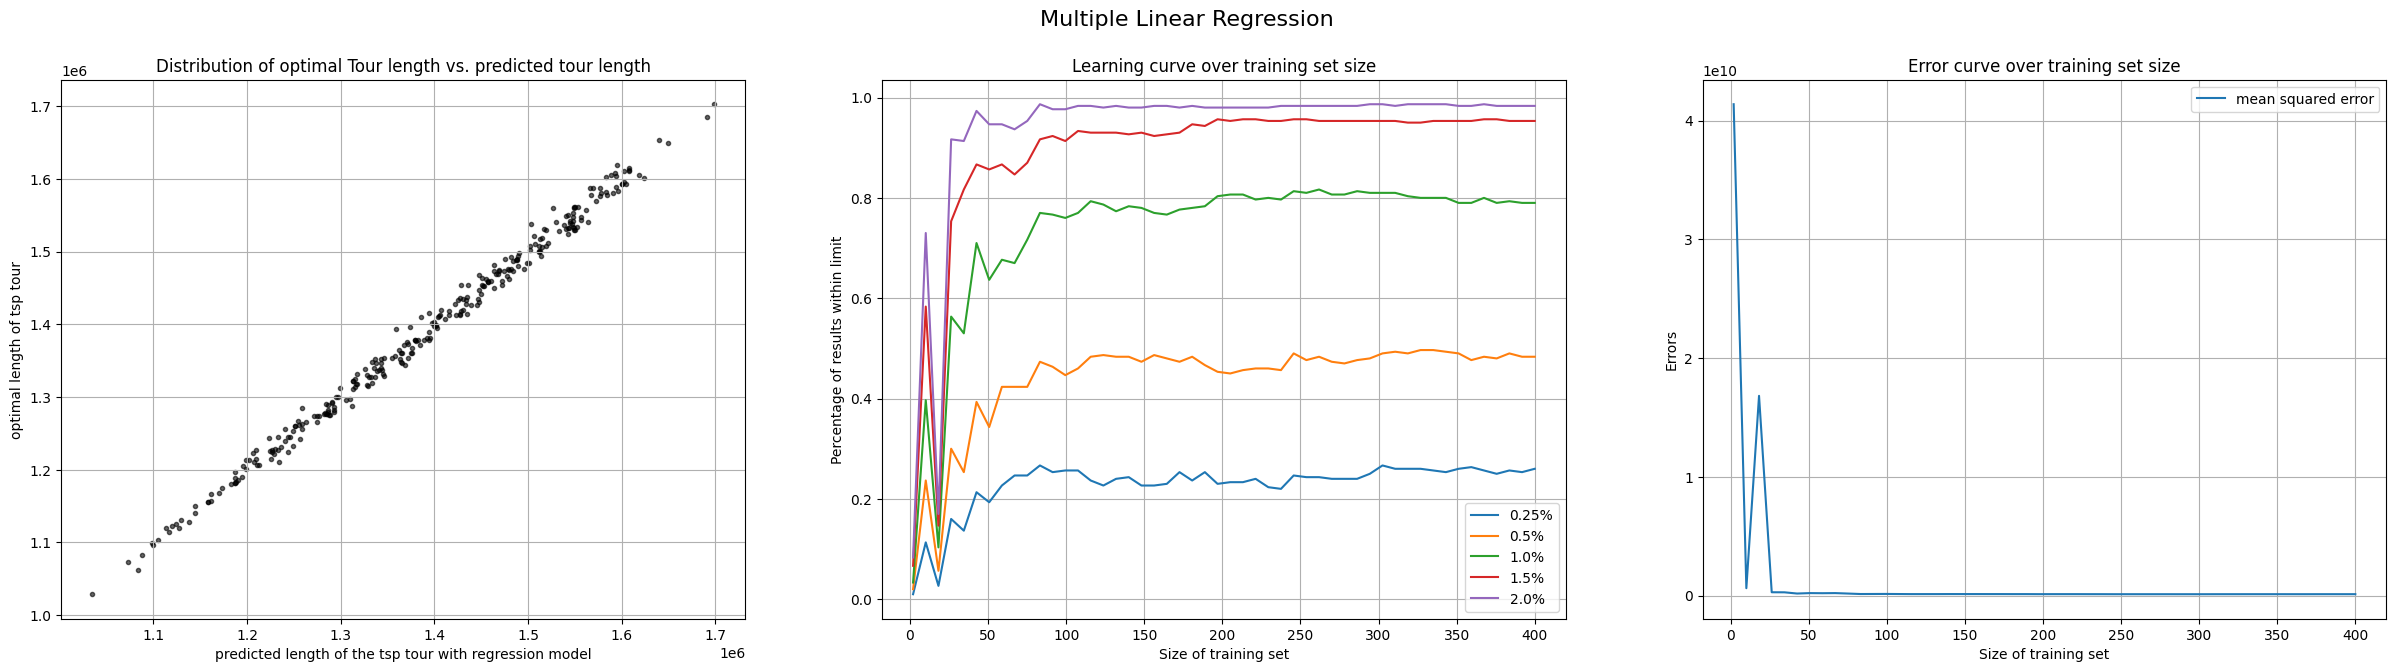

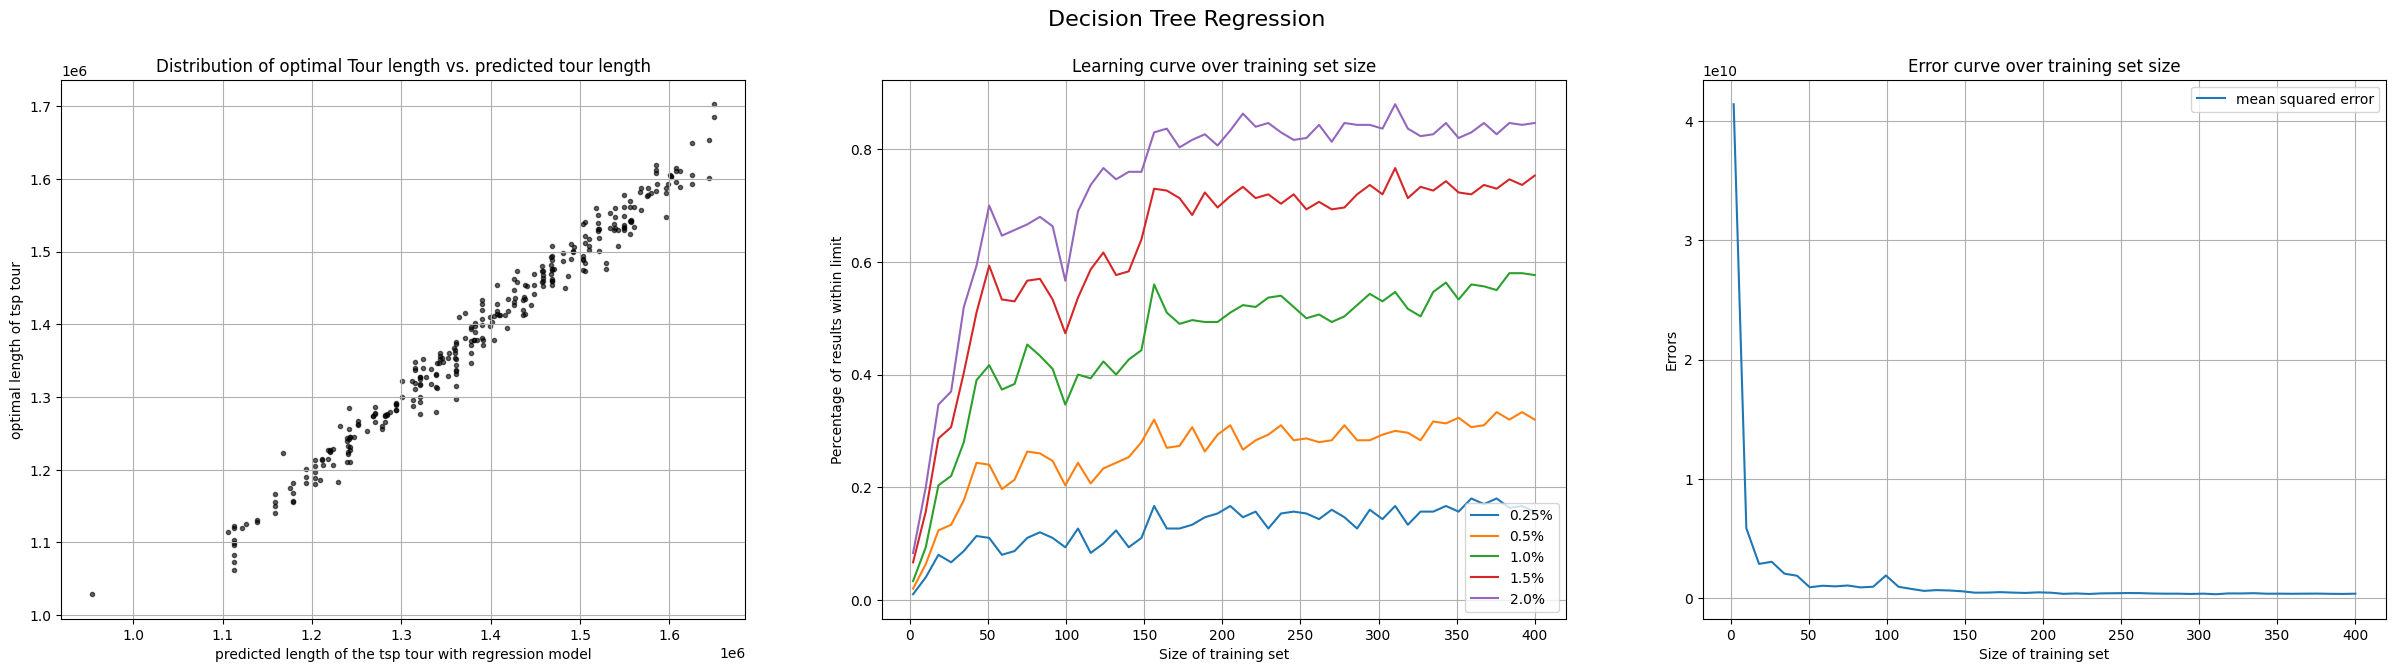

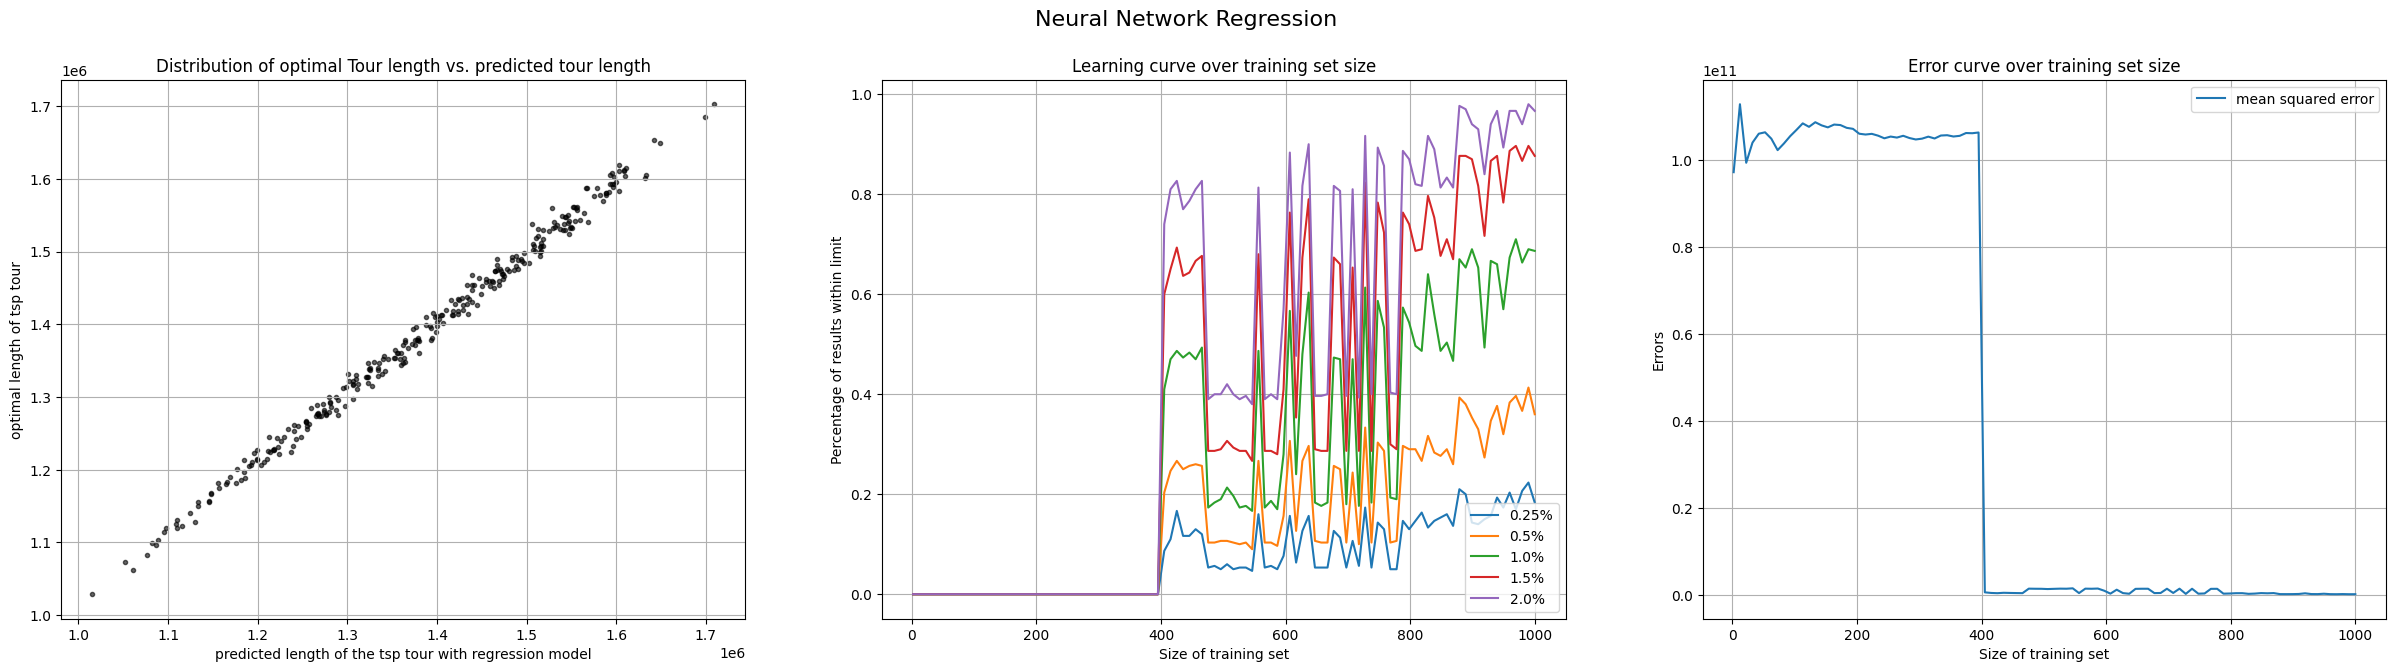

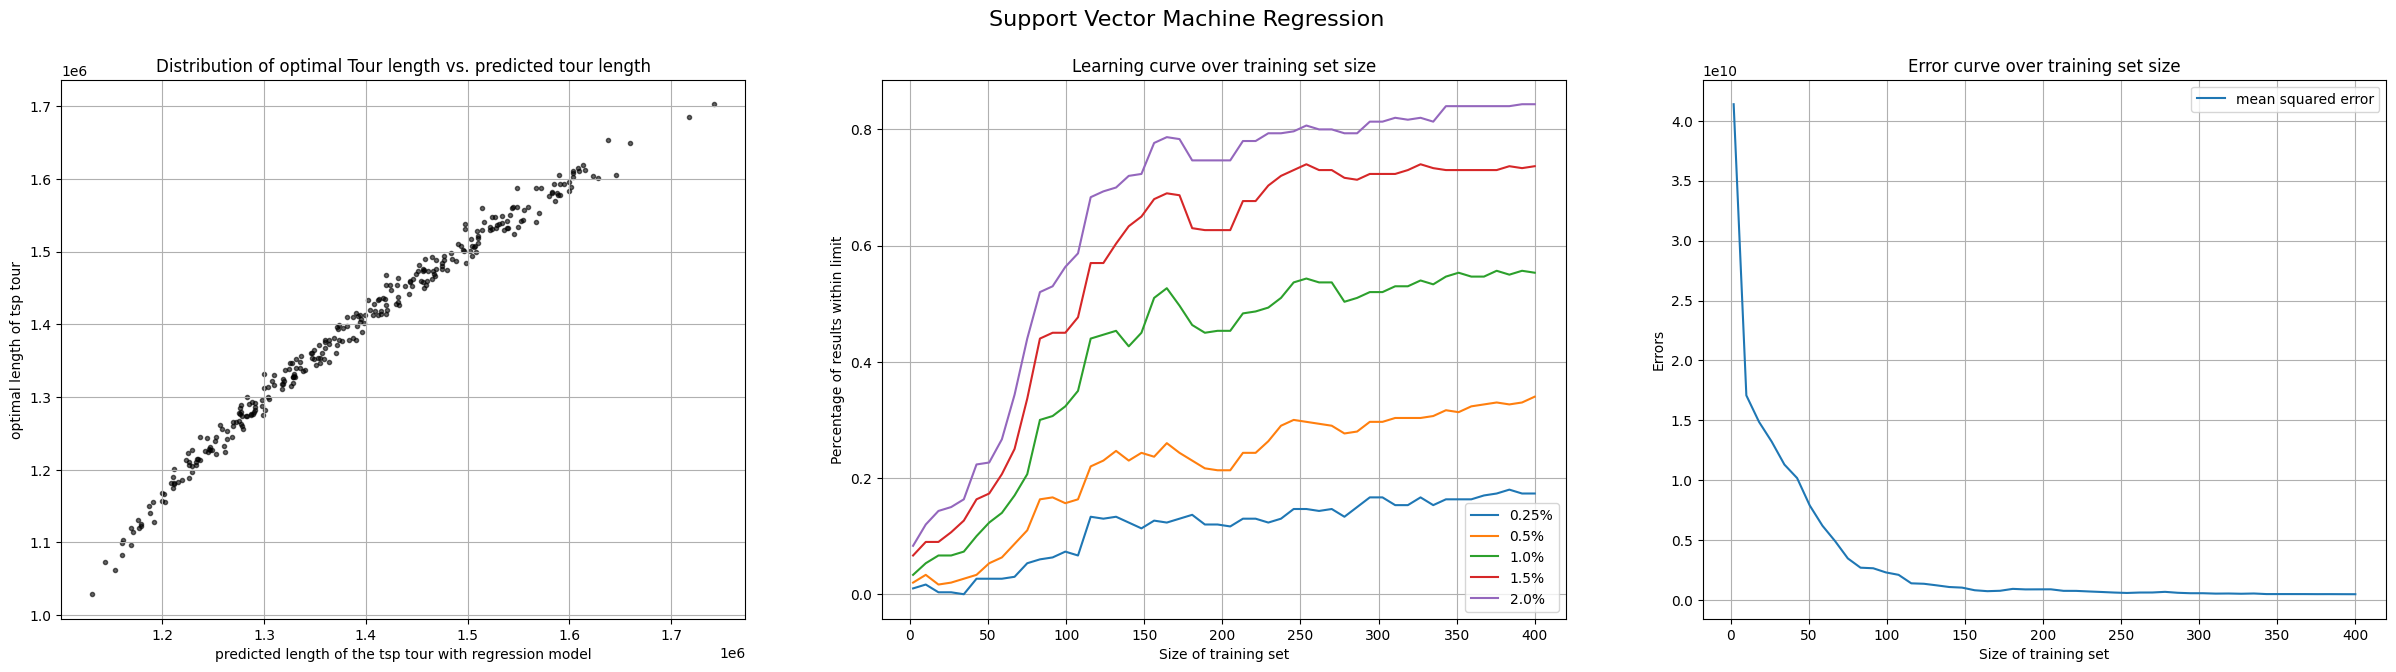

In [33]:
for name, config in models.items():
    model = config[0]
    train_set_size, results, errors = config[1]

    predictions, y_verify, results, errors = rg.train_models(
        X, y,
        model,
        train_set_size,
        results,
        errors
    )


    # atthe moment we cannot use the abs error
    del errors['mean_absolute_error']

    visualise_regression(
        predictions,
        y_verify,
        results,
        errors,
        train_set_size,
        name
    )

    r_2[name].append(r2_score(y_verify, predictions))

## Interpretation der Regressionsmodelle

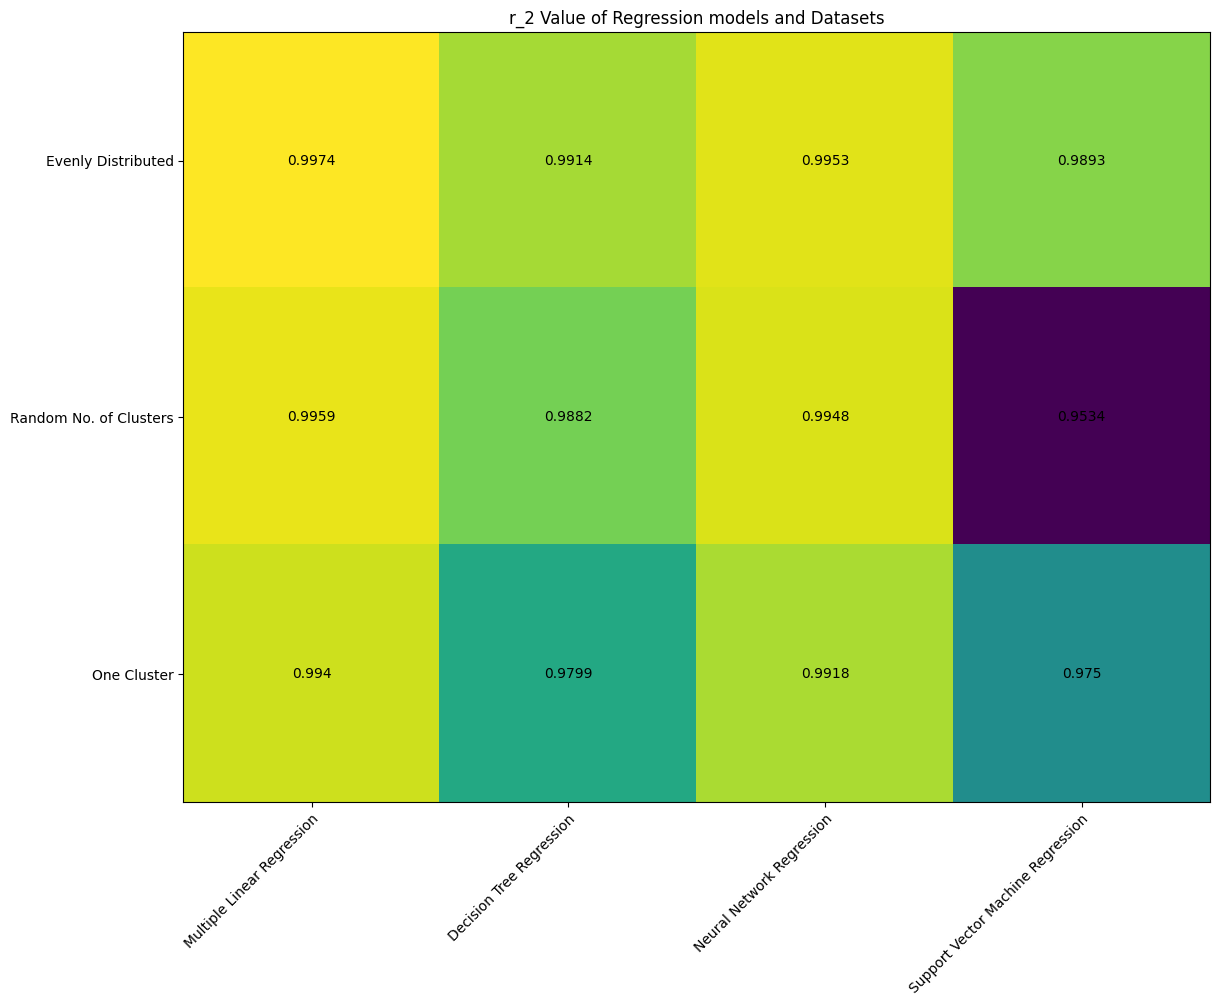

In [34]:
df_r_2 = pd.DataFrame(r_2, index=['Evenly Distributed', 'Random No. of Clusters', 'One Cluster'])

visualise_r_2_heatmap(df_r_2)

## Evaluation selbst berechneter Heuristiken

In [35]:
heuristics1_own = fo.get_all_heuristics(PATH_TSP1_HEU_OWN)

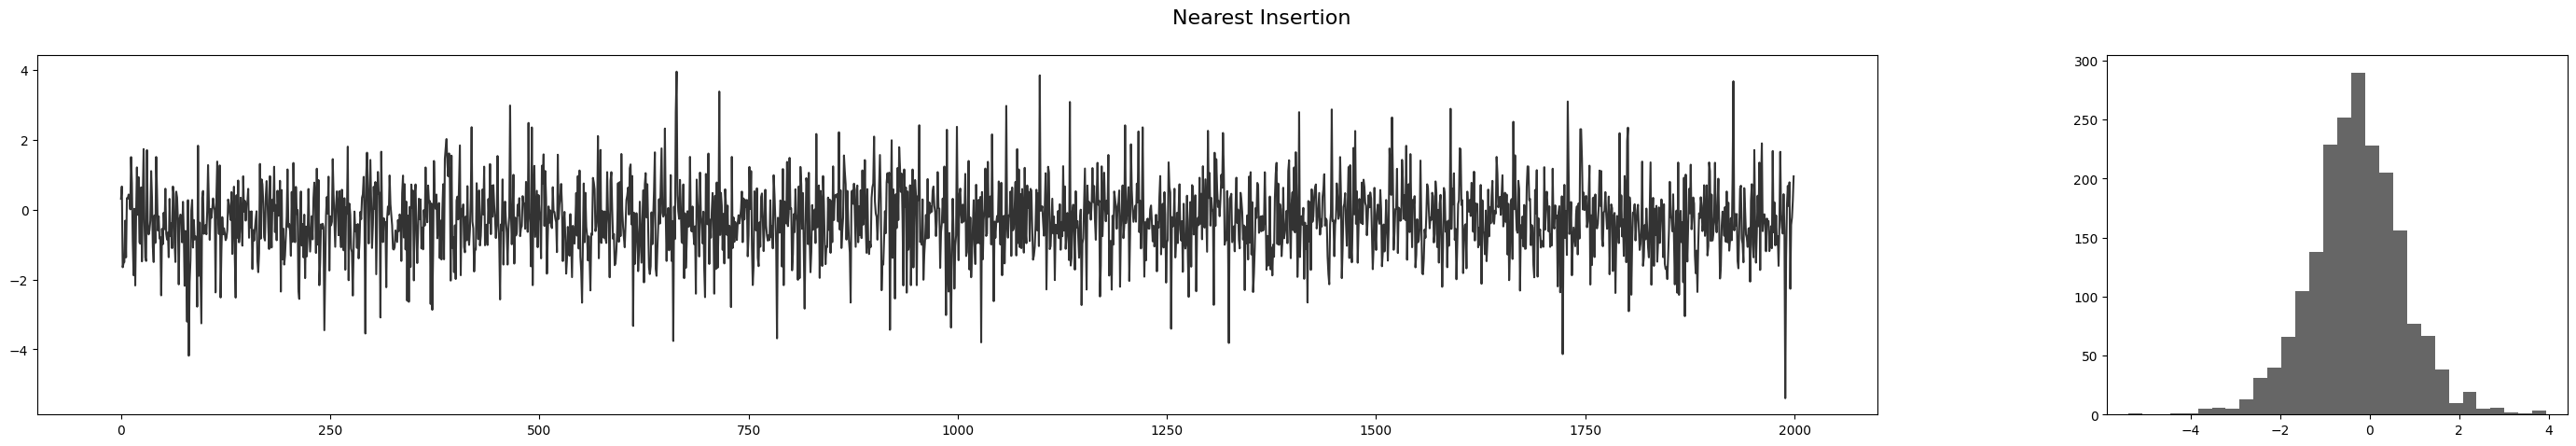

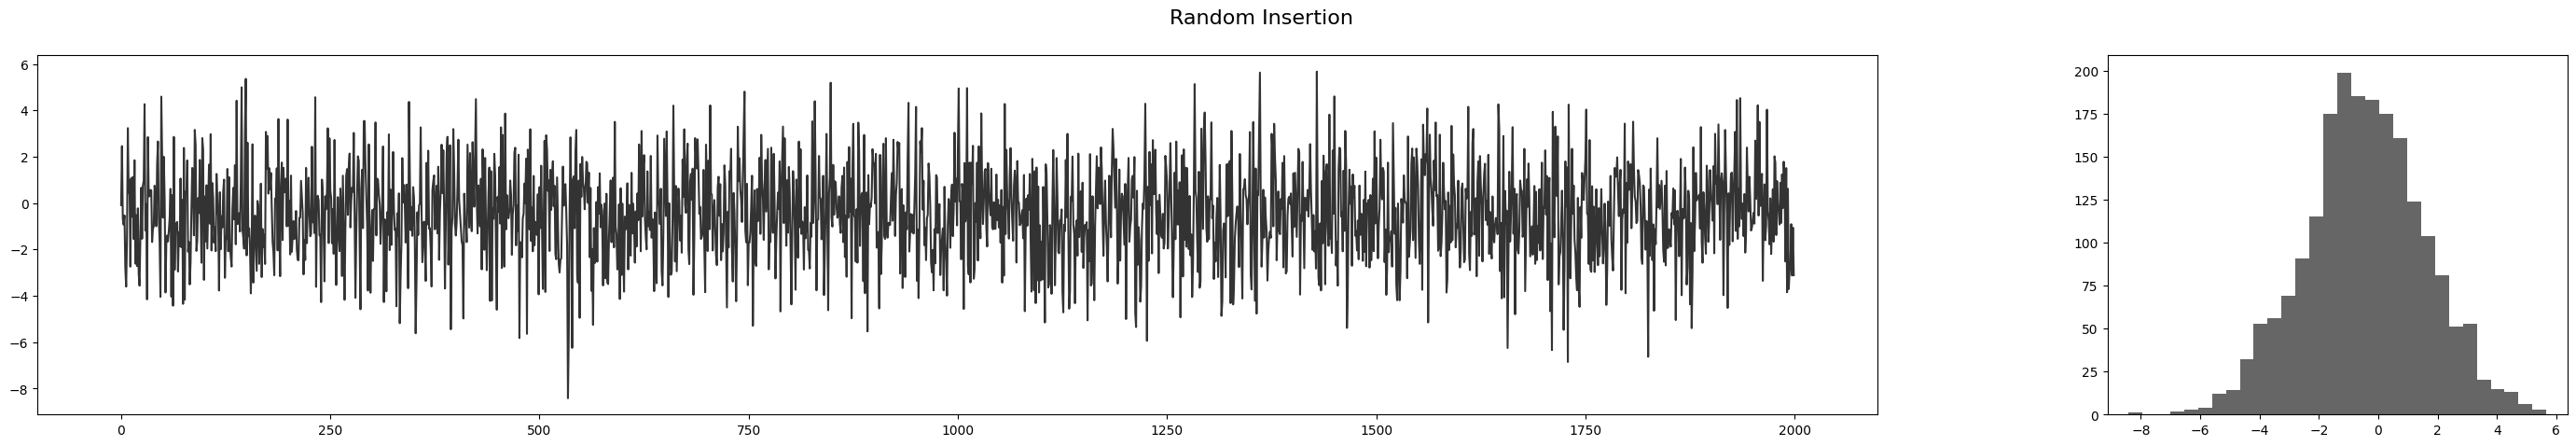

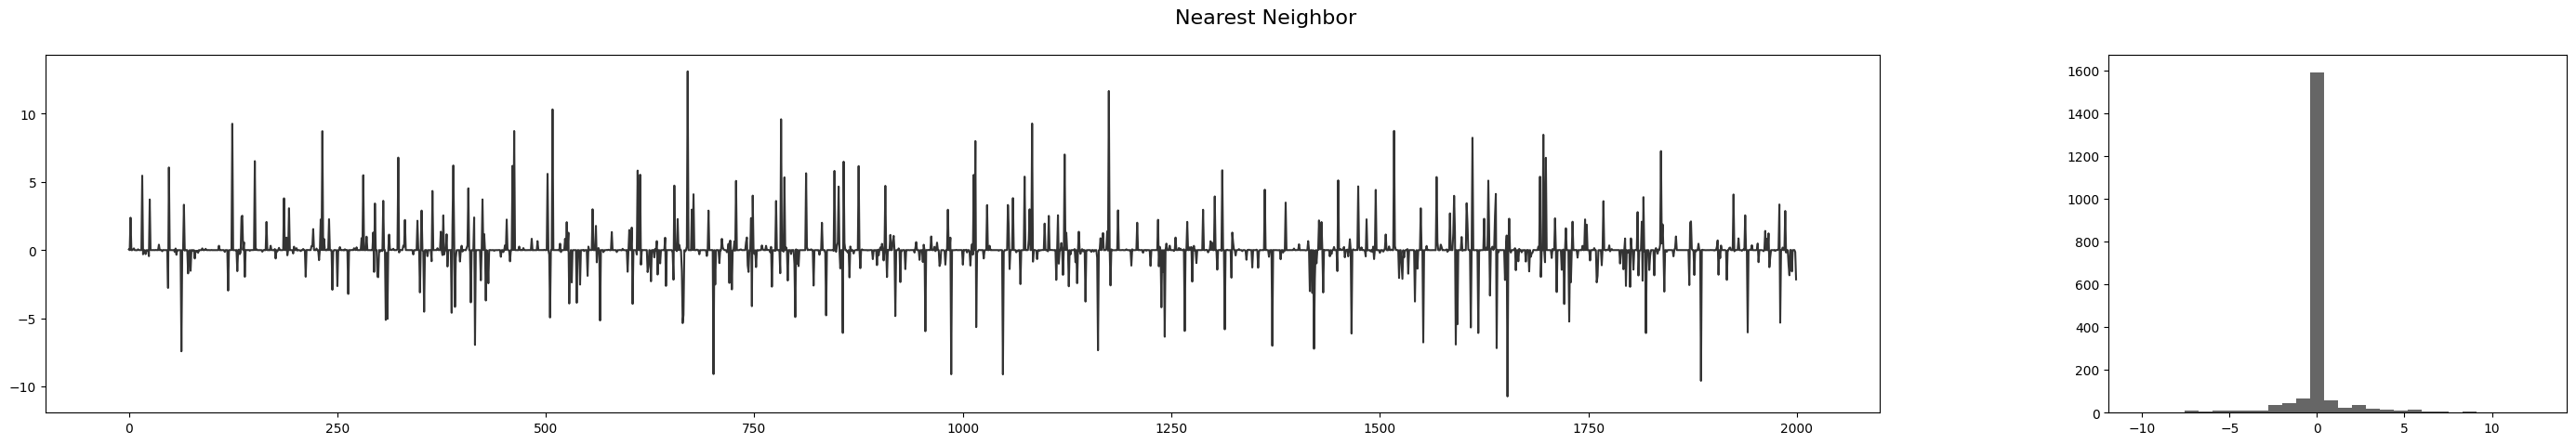

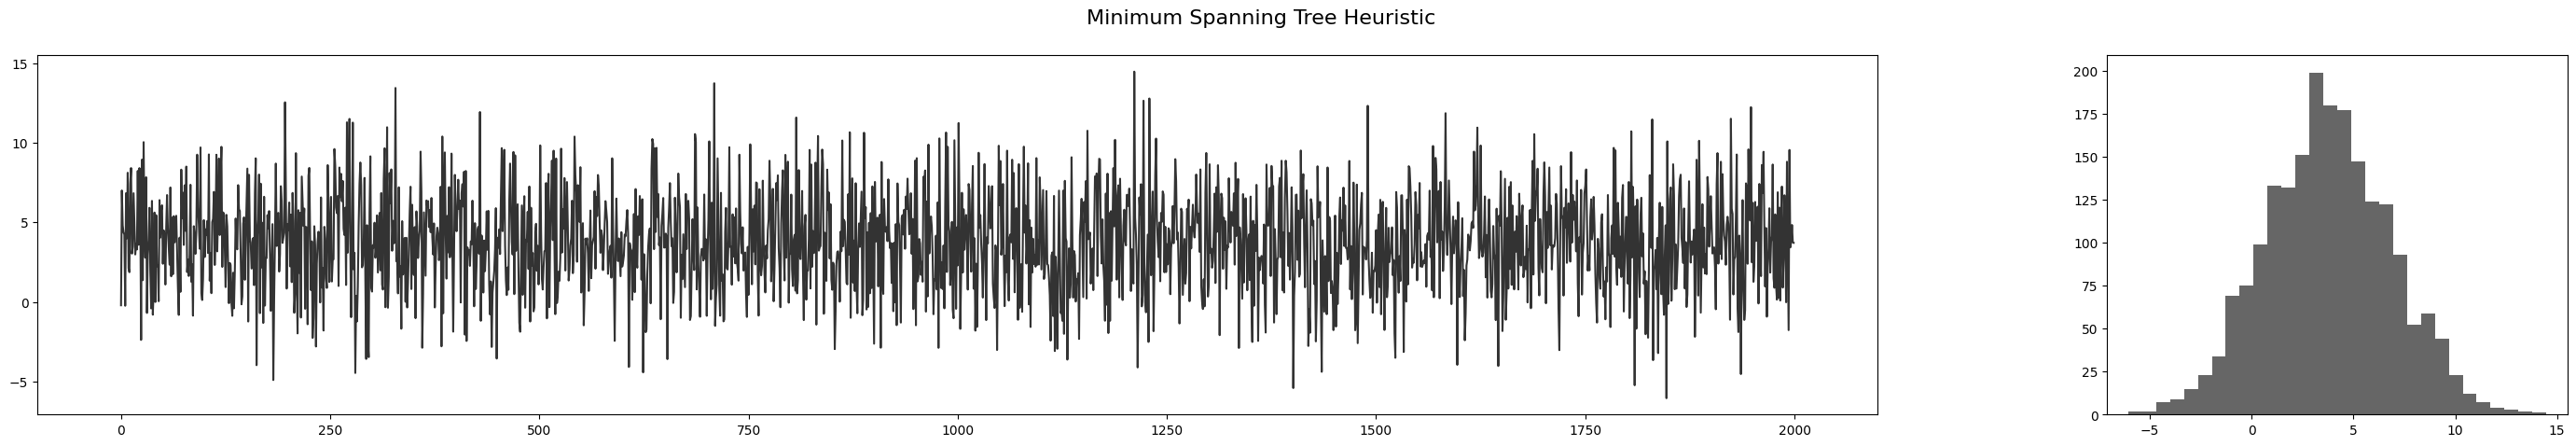

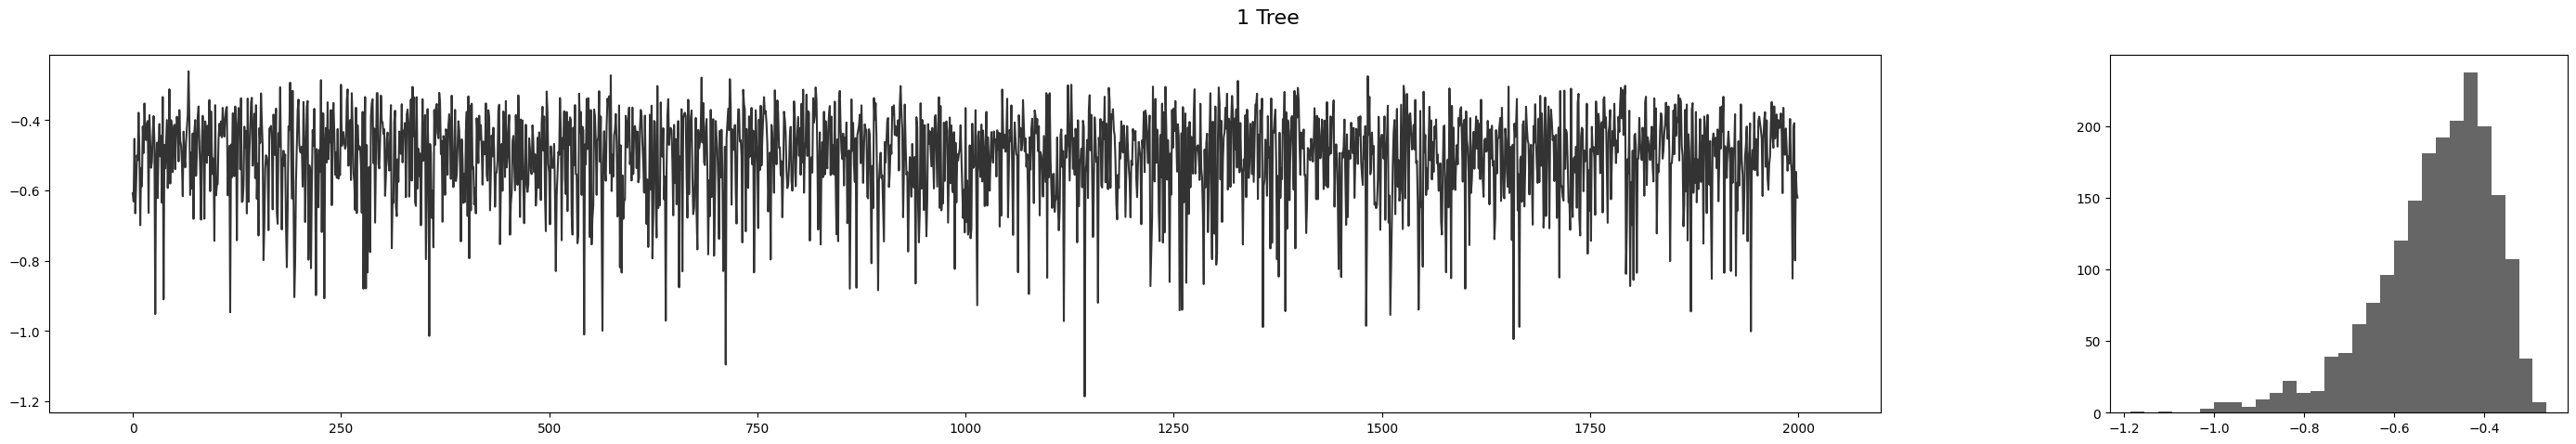

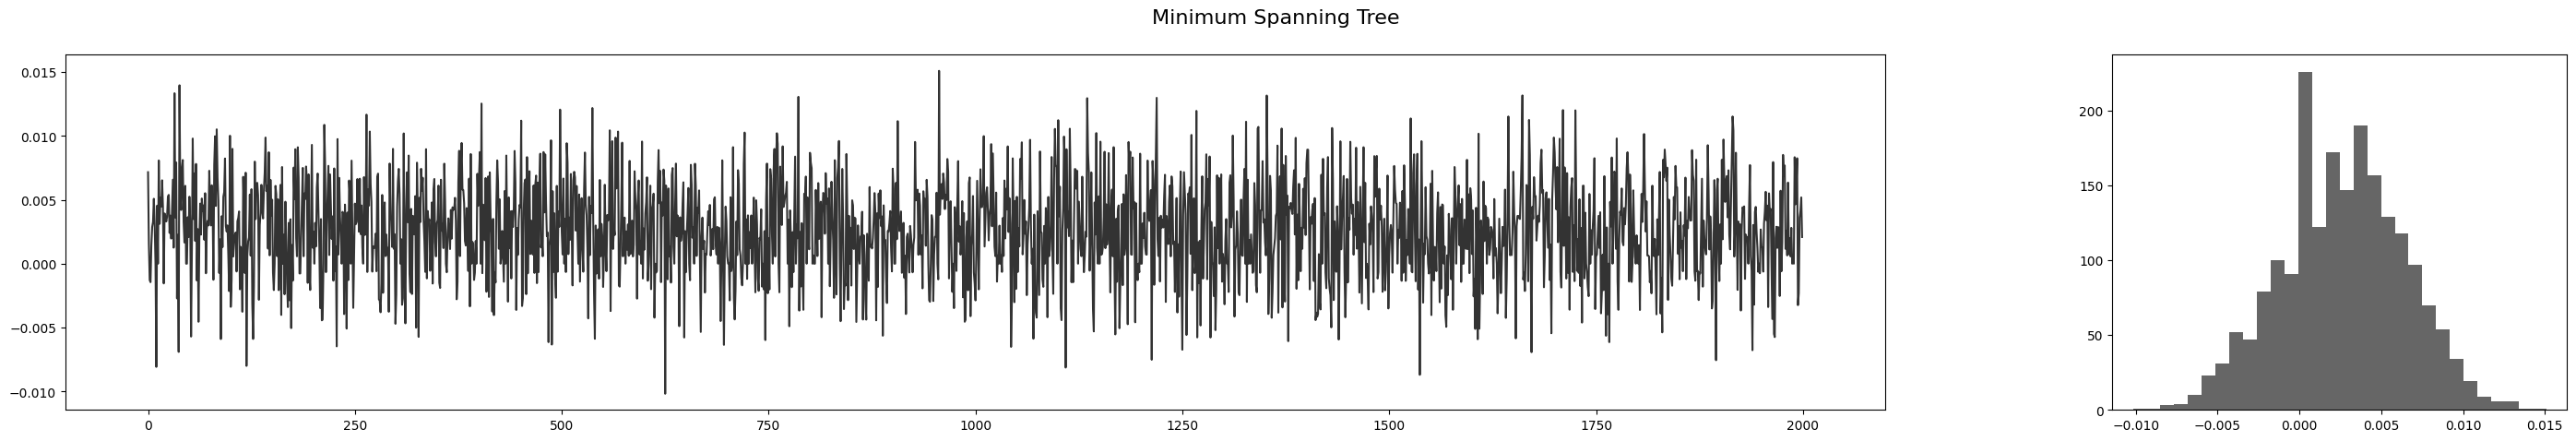

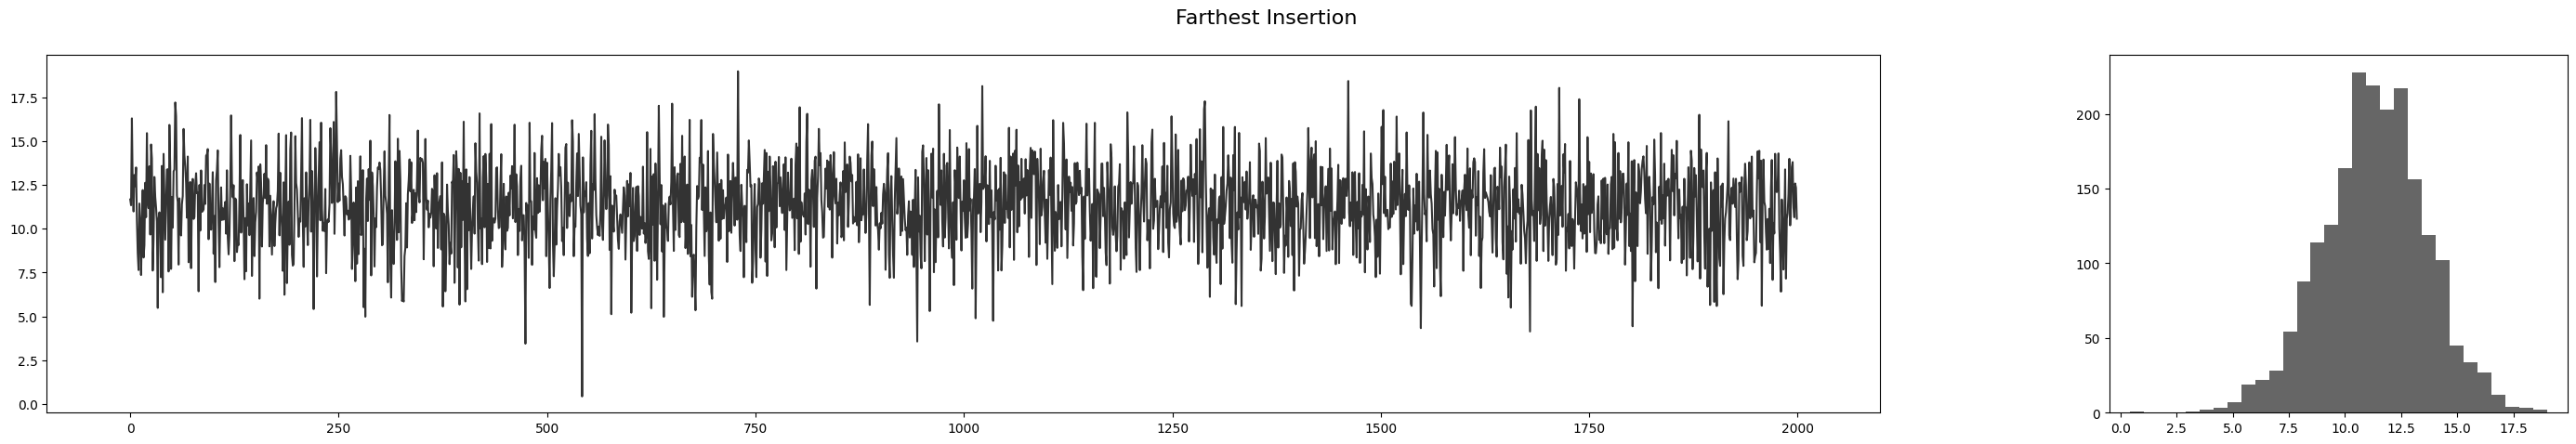

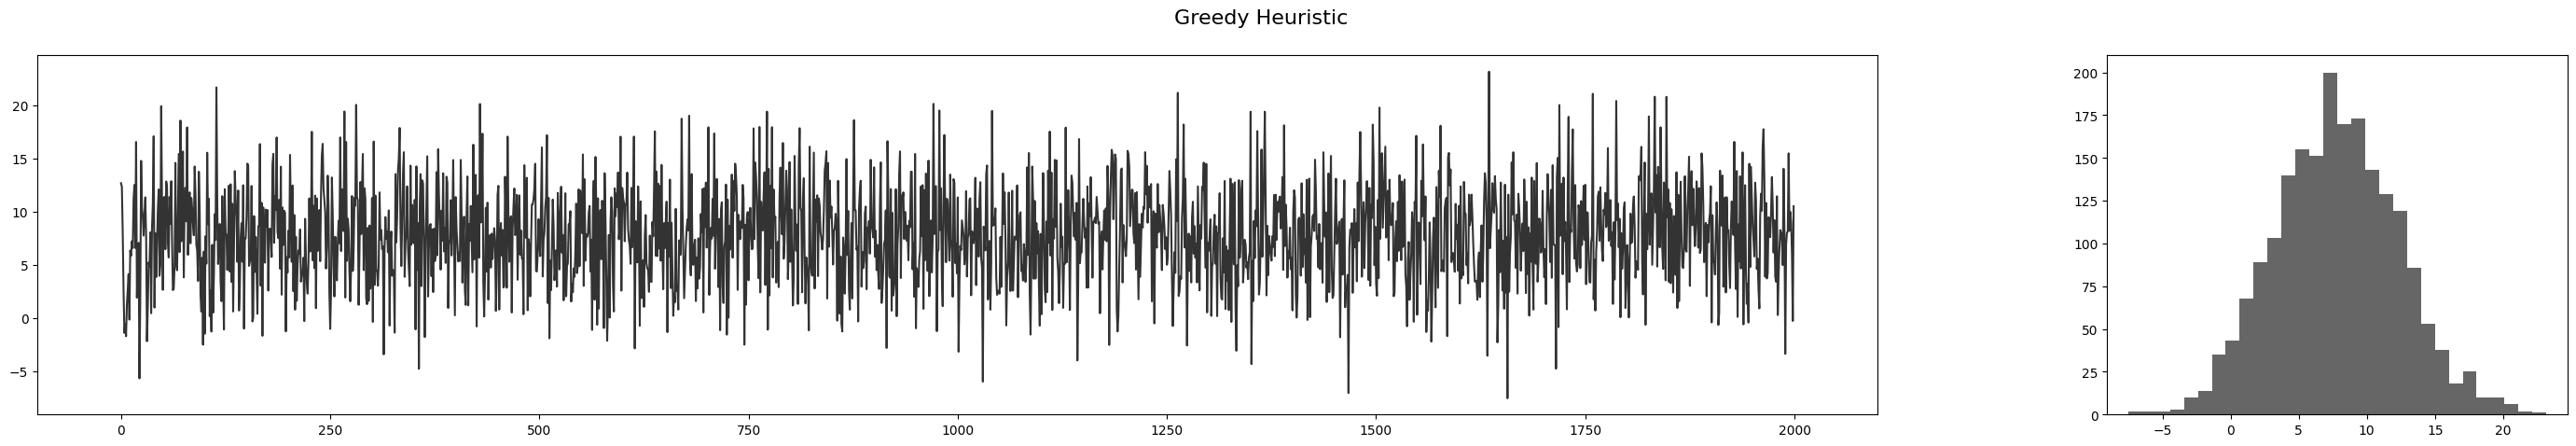

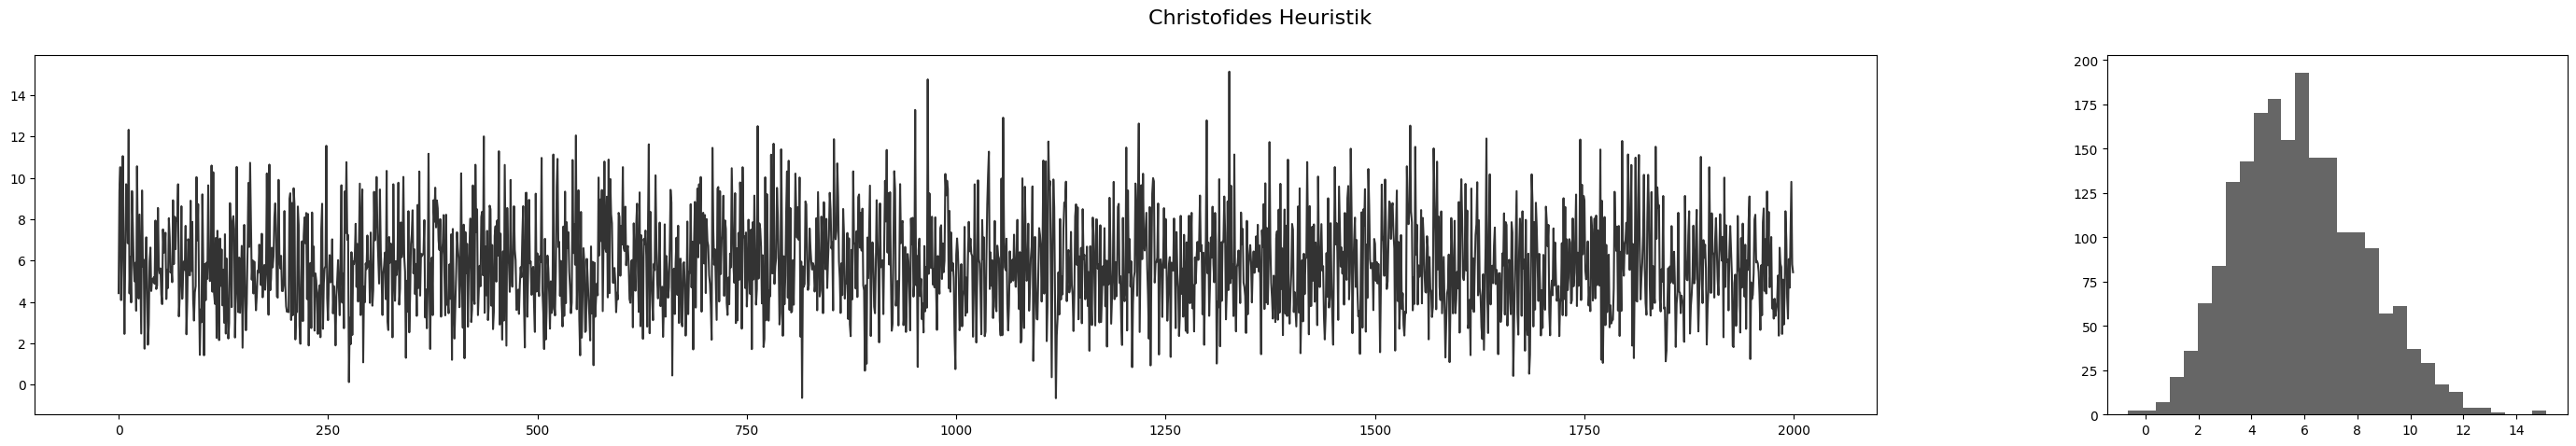

In [36]:
for key, value in heuristics1.items():
    if key != 'opt':
        visualise_heuristic_comparison(value, heuristics1_own[key], heuristics1_own['opt'], key)